# 1. LIBRERÍAS

Librerías más destacadas y su función en este notebook:

* `glob`: para trabajar con ficheros

* `os` y `os.path`: para operaciones con ficheros

* `pytorch`: para trabajar con tensores, estructuras de ML...


* `numpy`: para trabajar con estructuras matemáticas

* `matplotlib`:
> * `pyplot`: para mostrar gráficas e imágenes 
> * `image`: para mostrar imágenes
> * `colors`: para mapear colores de segmentación

* `sklearn`: para calcular medidas estadísticas

* `time`: para medir los tiempos de training


In [1]:
###############################
##### importing libraries #####
###############################
#Global Libraries
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import os, shutil
import glob
from tqdm import tqdm


#Torch 
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

#Open CV
import cv2

In [2]:
print(torch.__version__)

1.13.1+cu117


In [3]:
#pip install --upgrade torch torchvision

In [4]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [5]:
#pip install torchsummary

In [6]:
from torchsummary import summary


available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]## 1.2. Asignar GPU

In [7]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [8]:
#torch.cuda.memory_summary(device="cuda:2", abbreviated=False)

In [9]:
!nvidia-smi

Tue Feb 21 19:46:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   35C    P0    37W / 250W |    309MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   

In [10]:
# determine the device to be used for training and evaluation
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda:2" else False

cuda:2


# 2. Directories (COLAB vs. LOCAL) and Global Parameters


In [11]:
if 'google.colab' in str(get_ipython()):
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')
    os.chdir('/content/personal_drive/My Drive/UNED/TFM')
    base_dir = '/content/drive/MyDrive/Colab Notebooks/UNED-TFM'
    DATASET_PATH = os.path.join(base_dir, "Final Clinical Image")
    base_dir_clas = '/content/drive/MyDrive/Colab Notebooks/UNED-TFM/Federated Model'
    print('Running on CoLab')
else:
    os.chdir('../')
    base_dir = '.'
    base_dir_clas = '.'
    DATASET_PATH = os.path.join(base_dir, "Final Clinical Image")
    print('Not running on CoLab')

Not running on CoLab


In [12]:
!ls

'02. Base de Datos Organizado.zip'  'Output FedAVG'	      Scripts_zip.zip
 create_folder.ipynb		    'Output FedAVG_zip.zip'   test_zip.zip
 create_zip.ipynb		    'Output FedEN'	      TFM
 Delete_Folder.ipynb		    'Output Global'	      unzip.ipynb
'Final Clinical Image'		     Output.zip
'Final Clinical Image_aug'	     Scripts


In [13]:
DATASET_PATH

'./Final Clinical Image'

### **Global Parameters**

In [14]:
#######################################################
###### Hyperparameters for federated learning #########
#######################################################
# Methods ("AVG"/ "ENSEMBLE")
selected_method = "ENSEMBLE"
run = 1


#General Parameters
num_rounds = 500
epochs = 10
batch_size = 64
image_size = 128
learning_rate=0.0005

# Ensemble Method Parameters
K_models=5
Q_client_groups=2
ages=int(num_rounds/K_models)



### **Client Split according to the run**

In [15]:
# In case of Run where random split select number clients and percentage split
if run==2:
    split_perc = [0.5, 0.5]
elif run==3:
    split_perc = [0.33, 0.33, 0.34]
elif run==4:
    split_perc = [0.7, 0.15, 0.15]
elif run==5:
    split_perc = [0.4, 0.4, 0.2]
elif run==6:
    split_perc = [0.25, 0.25, 0.25, 0.25]
elif run==7:
    split_perc = [0.55, 0.15, 0.15, 0.15]
elif run==8:
    split_perc = [0.35, 0.35, 0.15, 0.15]
elif run==9:
    split_perc = [0.2, 0.2, 0.2, 0.2,0.2]
elif run==10:
    split_perc = [0.4, 0.15, 0.15, 0.15, 0.15]

#Number of clients
split="manual"
if run == 1:
    clients_list = ["A", "B"]
    num_clients = len(clients_list)
    split_perc = [0.87, 0.13]
else:
    clients_list = ["all"]
    num_clients = len(split_perc)
    split="random"

In [16]:
#List of parameters
Glob_Param = {"run": [run], "selected_method": [selected_method], "num_clients": [num_clients], "split": [split],
              "split_perc": [split_perc], "num_rounds": [num_rounds], "epochs": [epochs], 
              "batch_size": [batch_size], "image_size": [image_size], "learning_rate": [learning_rate],
              "ages": [ages], "K_models": [K_models], "Q_client_groups": [Q_client_groups]}

### **Get Image Directories**

In [17]:
def get_client_directories(list_clients, base_image_path):
  # Create list of directories to fill afterwards
  train_dir = {x: [] for x in list_clients} 
  validation_dir = {x: [] for x in list_clients} 
  test_dir = {x: [] for x in list_clients} 

  #Fill the list
  for client in list_clients:
    client_path = os.path.join(base_image_path, "ds_"+client)
    client_path_image = os.path.join(client_path, "images")
    train_dir[client].append(os.path.join(client_path_image, "train"))
    validation_dir[client].append(os.path.join(client_path_image, "valid"))
    test_dir[client].append(os.path.join(client_path_image, "test"))
  return train_dir, validation_dir, test_dir

In [18]:
train_dir, validation_dir, test_dir = get_client_directories(clients_list, DATASET_PATH)

Totals from ALL folder to get total figures

In [19]:
# In order to check total numbers we define ALL directories 
###############
# Dataset All #
###############
DATASET_PATH_ALL = os.path.join(DATASET_PATH, "ds_all")
DATASET_PATH_ALL_IMAGE = os.path.join(DATASET_PATH_ALL, "images")
# Directories for our training,
# validation and test splits
ALL_train_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'train')
ALL_validation_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'valid')
ALL_test_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'test')

#Check total numbers#
# Directory with our training benign pictures
ALL_train_ben_dir = os.path.join(ALL_train_dir, 'benign')
#print(train_ben_dir)
# Directory with our training malignant pictures
ALL_train_mal_dir = os.path.join(ALL_train_dir, 'malignant')
#print(train_mal_dir)
# Directory with our training normal pictures
ALL_train_nor_dir = os.path.join(ALL_train_dir, 'normal')
#print(train_nor_dir)

# Directory with our validation benign pictures
ALL_val_ben_dir = os.path.join(ALL_validation_dir, 'benign')
# Directory with our validation malignant pictures
ALL_val_mal_dir = os.path.join(ALL_validation_dir, 'malignant')
# Directory with our validation normal pictures
ALL_val_nor_dir = os.path.join(ALL_validation_dir, 'normal')

# Directory with our test benign pictures
ALL_test_ben_dir = os.path.join(ALL_test_dir, 'benign')
# Directory with our test malignant pictures
ALL_test_mal_dir = os.path.join(ALL_test_dir, 'malignant')
# Directory with our test normal pictures
ALL_test_nor_dir = os.path.join(ALL_test_dir, 'normal')

In [20]:
ls

'02. Base de Datos Organizado.zip'  'Output FedAVG'/          Scripts_zip.zip
 create_folder.ipynb                'Output FedAVG_zip.zip'   test_zip.zip
 create_zip.ipynb                   'Output FedEN'/           TFM/
 Delete_Folder.ipynb                'Output Global'/          unzip.ipynb
'Final Clinical Image'/              Output.zip
'Final Clinical Image_aug'/          Scripts/


### **Output Folders**

In [21]:
# define the path to the base output directory
if selected_method == "AVG":
    BASE_OUTPUT = os.path.join(base_dir_clas, "Output FedAVG")
if selected_method == "ENSEMBLE":
    BASE_OUTPUT = os.path.join(base_dir_clas, "Output FedEN")

BASE_OUPUT_RUN=os.path.join(BASE_OUTPUT, "Run "+str(run))


# define the path to the output serialized model, model training
# plot, and testing image paths

#MODEL_PATH = os.path.join(MODEL_PATH, "vgg16.pth")
MODEL_PATH = os.path.join(BASE_OUPUT_RUN, "Models")
MODEL_PATH_glob = os.path.join(MODEL_PATH, "vgg16_global.pth")
MODEL_PATH_best = os.path.join(MODEL_PATH, "vgg16_best.pth")
MODEL_PATH_param = os.path.join(MODEL_PATH, "model_param.txt")
MODEL_PATH_trans = os.path.join(MODEL_PATH, "model_augmen.txt")

#Plots
PLOT_PATH = os.path.join(BASE_OUPUT_RUN, "Plots")
PLOT_PATH_HIS = os.path.sep.join([PLOT_PATH, "plot_hist.json"])
PLOT_PATH_ACC = os.path.sep.join([PLOT_PATH, "plot_acc.png"])
PLOT_PATH_LOSS = os.path.sep.join([PLOT_PATH, "plot_loss.png"])

#Test Files
TEST_FILES_PATH = os.path.join(BASE_OUPUT_RUN, "Test Files")
TEST_PATHS = os.path.sep.join([TEST_FILES_PATH, "test_paths.txt"])


# 3. Get number of classes and Total Figures

In [22]:
train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(ALL_train_dir + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
#train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 
valid_image_paths = []
for data_path in glob.glob(ALL_validation_dir + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(flatten(valid_image_paths))


#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(ALL_test_dir + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  ./Final Clinical Image/ds_all/images/train/malignant/000298.png
class example:  malignant
Train size: 755
Valid size: 93
Test size: 95


In [23]:
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(test_image_paths))
f.close()

[INFO] saving testing image paths...


In [24]:
print('total training benign images:', len(os.listdir(ALL_train_ben_dir)))
print('total training malignant images:', len(os.listdir(ALL_train_mal_dir)))
print('total training normal images:', len(os.listdir(ALL_train_nor_dir)))
print("-----------------------------")
print('total validation benign images:', len(os.listdir(ALL_val_ben_dir)))
print('total validation malignant images:', len(os.listdir(ALL_val_mal_dir)))
print('total validation normal images:', len(os.listdir(ALL_val_nor_dir)))
print("-----------------------------")
print('total test benign images:', len(os.listdir(ALL_test_ben_dir)))
print('total test malignant images:', len(os.listdir(ALL_test_mal_dir)))
print('total test normal images:', len(os.listdir(ALL_test_nor_dir)))

total training benign images: 437
total training malignant images: 211
total training normal images: 107
-----------------------------
total validation benign images: 54
total validation malignant images: 26
total validation normal images: 13
-----------------------------
total test benign images: 55
total test malignant images: 27
total test normal images: 13


#######
       **Create dictionary for class indexes**
#######

In [25]:
num_classes=len(classes)
classes.sort()
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(idx_to_class )

{0: 'benign', 1: 'malignant', 2: 'normal'}


**B has one class less, so specific variable class if split is manual to get classes of B**

In [26]:
if split=="manual":
  classes_B = [] #to store class values

  #1.
  # get all the paths from train_data_path and append image paths and class to to respective lists
  # eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
  # eg. class -> 26.Pont_du_Gard
  for data_path in glob.glob(train_dir["B"][0] + '/*'):
      classes_B.append(data_path.split('/')[-1]) 
      train_image_paths.append(glob.glob(data_path + '/*'))

# 4. Create Dataset Pytorch

### **Transfomrs**

In [27]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(20),
        #transforms.RandomResizedCrop(image_size),
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        #transforms.RandomRotation(20),
        transforms.Resize((image_size,image_size)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

### **Create Dataset from Folders**

Function to merge datasets from different clients into one dataset

In [28]:
def merge_dataset(client_datasets):
    i=0
    for ds in client_datasets:
        if i==0:
            merge_ds=ds
        else:
            merge_ds+=ds
        i+=1
    return merge_ds

In [29]:
if split=="manual":
    train_dataset_client=[]
    test_dataset_client=[]
    val_dataset_client=[]
    i=0
    for client in clients_list:
        print(train_dir[client])
        train_dataset_client.append(datasets.ImageFolder(train_dir[client][0], transform=train_transforms))
        test_dataset_client.append(datasets.ImageFolder(test_dir[client][0], transform=test_transforms))
        val_dataset_client.append(datasets.ImageFolder(validation_dir[client][0], transform=test_transforms))
        #validation_dataset+=datasets.ImageFolder(validation_dir[client][0], transform=test_transforms)
        #test_dataset+=datasets.ImageFolder(test_dir[client][0], transform=test_transforms)
    test_dataset=merge_dataset(test_dataset_client)
    validation_dataset=merge_dataset(val_dataset_client)
#We take the entire dataset "ALL", so we only have one client in the list and we need to apply .random_split
else:
    for client in clients_list:
        train_dataset_glob = datasets.ImageFolder(train_dir[client][0], transform=train_transforms)
        train_dataset_client = torch.utils.data.random_split(train_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        test_dataset_glob = datasets.ImageFolder(test_dir[client][0], transform=test_transforms)
        test_dataset_client = torch.utils.data.random_split(test_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        validation_dataset_glob = datasets.ImageFolder(validation_dir[client][0], transform=test_transforms)
        val_dataset_client = torch.utils.data.random_split(validation_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        #If random split then the glob dataset contains the full population
        validation_dataset=validation_dataset_glob
        test_dataset=test_dataset_glob

['./Final Clinical Image/ds_A/images/train']
['./Final Clinical Image/ds_B/images/train']


In [30]:
def remove_hide_file(folder):
    shutil.rmtree(folder+'/images/test/.ipynb_checkpoints/')
    shutil.rmtree(folder+'/images/train/.ipynb_checkpoints/')
    shutil.rmtree(folder+'/images/valid/.ipynb_checkpoints/')
    return





### **Load Dataset Pytorch**

In [31]:
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in train_dataset_client]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
val_loader_client = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in val_dataset_client]


# 5. Define Neural Network

In [32]:
################################
##### Neural Network model #####
################################

cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(512*image_size/32*image_size/32), 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        output = F.log_softmax(out, dim=1)
        return output

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

### **Save the best model**

In [33]:
class SaveBestModel():
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), best_valid_acc=float('inf'), best_comunication_round=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        self.best_valid_acc = best_valid_acc
        self.best_comunication_round = best_comunication_round
        
    def __call__(
        self, current_valid_loss,current_valid_acc, 
        comunication_round, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            self.best_valid_acc = current_valid_acc
            self.best_comunication_round = comunication_round
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for comunication round: {comunication_round}\n")
            torch.save(model, MODEL_PATH_best)

# 6. Federated Functions

### **Client Train Local Model**

In [34]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    client_model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            data = data.float()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

### **Server Aggregate Models**

In [35]:
def server_aggregate(global_model_agg, client_models,method,client_group=None):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    if method == "ENSEMBLE":
      global_dict = global_model_agg.state_dict()
      for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in client_group], 0).mean(0)
      global_model_agg.load_state_dict(global_dict)

    if method == "AVG":
      global_dict = global_model_agg.state_dict()
      for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model_agg.load_state_dict(global_dict)
      for model in client_models:
        model.load_state_dict(global_model_agg.state_dict())

### **Test Server Model**

In [36]:
def test(global_model_test, test_loader,method):
    """This function test the global model on test data and returns test loss and test accuracy """
    if method == "ENSEMBLE":
      for model in global_model_test:
          model.eval()
    else:
      global_model_test.eval()

    pred_final=[]
    target_final=[]
    correct = 0
    test_loss = 0
    confusion_matrix_torch = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
                  data, target = data.to(DEVICE), target.to(DEVICE)
                  data = data.float()

                  if method == "ENSEMBLE": 
                    global_output=[]
                    for model in global_model_test:
                      output_model = model(data)
                      global_output.append(output_model)
                    final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
                    test_loss += F.nll_loss(final_output[0], target, reduction='sum').item()  # sum up batch loss
                    pred = final_output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()

                  if method == "AVG":
                    output = global_model_test(data)
                    test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()

                  for t, p in zip(target.view(-1), pred.view(-1)):
                    confusion_matrix_torch[t.long(), p.long()] += 1
                  pred_final.extend(pred.to('cpu').numpy().tolist())
                  target_final.extend(target.to('cpu').numpy().tolist())


 
    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)


    return test_loss, acc, confusion_matrix_torch

# 7. Initialize and Train

### **Initializae**

In [37]:
############################################
#### Initializing models and optimizer  ####
############################################


if selected_method == "AVG":
  #### K global model ##########
  global_model = VGG('VGG16').to(DEVICE) 

  #summary(VGG('VGG16'), (1,image_size,image_size))
  ############## client models ##############
  client_models = [ VGG('VGG16').to(DEVICE)  for _ in range(num_clients)]
  for model in client_models:
      model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

  ############### optimizers ################
  opt = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

if selected_method == "ENSEMBLE":
  #### K global model ##########
  Model_list = list(range(K_models))
  global_models_ensemble = [ VGG('VGG16').to(DEVICE) for _ in range(K_models)]
  #summary(global_models_ensemble[0], (1,image_size,image_size))
  ############## client models ##############
  Client_groups = []
  n =  list(range(num_clients))
  for index in range(Q_client_groups):
    group = n[index::Q_client_groups]
    Client_groups.append(group)
  client_models = [ VGG('VGG16').to(DEVICE) for _ in range(num_clients)]
  print(Client_groups)
  ############### optimizers ################
  opt = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

# initialize SaveBestModel class
save_best_model = SaveBestModel()

############### Results ###################
H = {"train_loss": [], "test_loss": [], "test_acc": []}
Best={"Best Communication round": [], "Best Valid Loss": [], "Best Valid Acc": []}

[[0], [1]]


### **Train**

In [38]:
###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL
comunication_round=0
if selected_method == "AVG":
    for r in range(num_rounds):
        # client update
        loss = 0
        for i in tqdm(range(num_clients)):
            loss += client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)
            
        
        losses_train.append(loss)
        # server aggregate
        server_aggregate(global_model, client_models , method=selected_method)
        
        test_loss, acc, confusion_matrix_torch = test(global_model, test_loader, method=selected_method)


        losses_test.append(test_loss)
        acc_test.append(acc)
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_clients, test_loss, acc))
        if r%10 == 0:
            print("Confusion Matrix: ", confusion_matrix_torch)
        H["train_loss"].append(loss / num_clients)
        H["test_loss"].append(test_loss)
        H["test_acc"].append(acc)
        save_best_model(test_loss, acc,comunication_round, global_model)
        comunication_round+=1
        
if selected_method == "ENSEMBLE":
  # Runnining FL algorithm for Ensemble Method
    for t in range(ages):
        print("Ages: ",t)
  #Create Permutation Matrix for this Age Iteration
        P_matrix=[]
        for q in range(Q_client_groups):
            model_permu = list(range(K_models))
            random.shuffle(model_permu)
            P_matrix.append(model_permu)

        for r in tqdm(range(K_models)):
            #print("Communication round: ",r)
            for q in range(Q_client_groups):
            #Train the model for the specific K-communication step and for the specific Stratum
                #print("Group Clients: ",q)
                #print("Model for this Group Clients and Communication round: ",P_matrix[q][r])
                print("Model {} for Group Clients {} and Communication round {}".format(P_matrix[q][r], q, r))
                #global_model=global_models_ensemble[P_matrix[q][r]]
                #For every client in the startus, update the weights to the specific model according to the permutation matrix
                loss = 0
                for i in Client_groups[q]:
                  #print("Train Client: ", i)
                  client_models[i].load_state_dict(global_models_ensemble[P_matrix[q][r]].state_dict())
                  # client update
                  loss += client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)
            #Server update for the model that has been localy trained 
            for q in range(Q_client_groups):
                print("Updating model in the server...")
                server_aggregate(global_models_ensemble[P_matrix[q][r]], client_models,method=selected_method,client_group=Client_groups[q])

            losses_train.append(loss)
            # server aggregate

            print("Testing in the server all the models...")
            test_loss, acc, confusion_matrix_torch = test(global_models_ensemble, test_loader,method=selected_method)


            losses_test.append(test_loss)
            acc_test.append(acc)
            print('%d-th round, in age %d-th' % (r,t))
            print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_clients, test_loss, acc))
            if r == K_models-1:
                print("Confusion Matrix: ", confusion_matrix_torch)
            H["train_loss"].append(loss / num_clients)
            H["test_loss"].append(test_loss)
            H["test_acc"].append(acc) 
            save_best_model(test_loss, acc,comunication_round, global_models_ensemble)
            comunication_round+=1
            
#Save Best Model Round and Loss
Best["Best Communication round"].append(save_best_model.best_comunication_round)
Best["Best Valid Loss"].append(save_best_model.best_valid_loss) 
Best["Best Valid Acc"].append(save_best_model.best_valid_acc) 

  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  0
Model 2 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 0-th
average train loss 0.531 | test loss 1.07 | test acc: 0.579

Best validation loss: 1.0731774179559006

Saving best model for comunication round: 0



 20%|██        | 1/5 [01:37<06:31, 98.00s/it]

Model 1 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 0-th
average train loss 0.511 | test loss 1.05 | test acc: 0.579

Best validation loss: 1.0471154463918586

Saving best model for comunication round: 1



 40%|████      | 2/5 [03:09<04:41, 93.91s/it]

Model 0 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 0-th
average train loss 0.512 | test loss 1.03 | test acc: 0.579

Best validation loss: 1.025775146484375

Saving best model for comunication round: 2



 60%|██████    | 3/5 [04:39<03:04, 92.38s/it]

Model 3 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 0-th
average train loss 0.441 | test loss 0.997 | test acc: 0.579

Best validation loss: 0.9966853091591283

Saving best model for comunication round: 3



 80%|████████  | 4/5 [06:11<01:32, 92.33s/it]

Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 0-th
average train loss 0.463 | test loss 0.963 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.9630481117650083

Saving best model for comunication round: 4



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  1
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 1-th
average train loss 0.451 | test loss 0.954 | test acc: 0.579

Best validation loss: 0.954272420782792

Saving best model for comunication round: 5



 20%|██        | 1/5 [01:32<06:09, 92.47s/it]

Model 0 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 1-th
average train loss 0.476 | test loss 0.938 | test acc: 0.579

Best validation loss: 0.9377359089098478

Saving best model for comunication round: 6



 40%|████      | 2/5 [03:03<04:35, 91.89s/it]

Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 1-th
average train loss 0.409 | test loss 0.93 | test acc: 0.579

Best validation loss: 0.9300624245091489

Saving best model for comunication round: 7



 60%|██████    | 3/5 [04:35<03:03, 91.67s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 1-th
average train loss 0.386 | test loss 0.924 | test acc: 0.579

Best validation loss: 0.9239895870811061

Saving best model for comunication round: 8



 80%|████████  | 4/5 [06:06<01:31, 91.39s/it]

Model 4 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 1-th
average train loss 0.408 | test loss 0.915 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.9146162334241366

Saving best model for comunication round: 9



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  2
Model 3 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 2-th
average train loss 0.417 | test loss 0.911 | test acc: 0.579

Best validation loss: 0.9110941435161389

Saving best model for comunication round: 10



 20%|██        | 1/5 [01:32<06:11, 92.79s/it]

Model 1 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 2-th
average train loss 0.409 | test loss 0.908 | test acc: 0.579

Best validation loss: 0.9081305252878289

Saving best model for comunication round: 11



 40%|████      | 2/5 [03:05<04:38, 92.84s/it]

Model 4 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 2-th
average train loss 0.406 | test loss 0.905 | test acc: 0.579

Best validation loss: 0.9046781841077303

Saving best model for comunication round: 12



 60%|██████    | 3/5 [04:38<03:05, 92.83s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 2-th
average train loss 0.418 | test loss 0.9 | test acc: 0.579

Best validation loss: 0.8998757211785567

Saving best model for comunication round: 13



 80%|████████  | 4/5 [06:20<01:36, 96.52s/it]

Model 0 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 2-th
average train loss 0.444 | test loss 0.897 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.8974600139417146

Saving best model for comunication round: 14



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  3
Model 2 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 3-th
average train loss 0.394 | test loss 0.897 | test acc: 0.579

Best validation loss: 0.8966446725945724

Saving best model for comunication round: 15



 20%|██        | 1/5 [01:43<06:55, 103.81s/it]

Model 1 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 3-th
average train loss 0.436 | test loss 0.894 | test acc: 0.579

Best validation loss: 0.8944584896689967

Saving best model for comunication round: 16



 40%|████      | 2/5 [03:31<05:17, 105.93s/it]

Model 0 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 3-th
average train loss 0.403 | test loss 0.891 | test acc: 0.579

Best validation loss: 0.8912979929070723

Saving best model for comunication round: 17



 60%|██████    | 3/5 [05:12<03:27, 103.80s/it]

Model 3 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 3-th
average train loss 0.375 | test loss 0.889 | test acc: 0.579

Best validation loss: 0.8887826618395354

Saving best model for comunication round: 18



 80%|████████  | 4/5 [06:45<01:39, 99.36s/it] 

Model 4 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 3-th
average train loss 0.386 | test loss 0.884 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.8838108263517681

Saving best model for comunication round: 19



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  4
Model 0 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 4-th
average train loss 0.402 | test loss 0.884 | test acc: 0.579

Best validation loss: 0.8835452029579565

Saving best model for comunication round: 20



 20%|██        | 1/5 [01:32<06:10, 92.58s/it]

Model 2 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 4-th
average train loss 0.398 | test loss 0.883 | test acc: 0.579

Best validation loss: 0.8825012608578331

Saving best model for comunication round: 21



 40%|████      | 2/5 [03:05<04:38, 92.75s/it]

Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 4-th
average train loss 0.383 | test loss 0.878 | test acc: 0.579

Best validation loss: 0.8777455380088405

Saving best model for comunication round: 22



 60%|██████    | 3/5 [04:40<03:07, 93.60s/it]

Model 1 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 4-th
average train loss 0.397 | test loss 0.874 | test acc: 0.579

Best validation loss: 0.8741973475406044

Saving best model for comunication round: 23



 80%|████████  | 4/5 [06:12<01:33, 93.22s/it]

Model 3 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 4-th
average train loss 0.39 | test loss 0.874 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.8735810932360197

Saving best model for comunication round: 24



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  5
Model 4 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 5-th
average train loss 0.402 | test loss 0.872 | test acc: 0.579

Best validation loss: 0.8719053168045847

Saving best model for comunication round: 25



 20%|██        | 1/5 [01:35<06:20, 95.21s/it]

Model 1 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:06<04:38, 92.84s/it]

1-th round, in age 5-th
average train loss 0.422 | test loss 0.873 | test acc: 0.579
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:38<03:04, 92.43s/it]

2-th round, in age 5-th
average train loss 0.379 | test loss 0.872 | test acc: 0.579
Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 5-th
average train loss 0.382 | test loss 0.87 | test acc: 0.579

Best validation loss: 0.869951709948088

Saving best model for comunication round: 28



 80%|████████  | 4/5 [06:13<01:33, 93.46s/it]

Model 0 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 5-th
average train loss 0.352 | test loss 0.869 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.8689592461836966

Saving best model for comunication round: 29



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  6
Model 1 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 6-th
average train loss 0.375 | test loss 0.869 | test acc: 0.579

Best validation loss: 0.8689327440763774

Saving best model for comunication round: 30



 20%|██        | 1/5 [01:33<06:14, 93.64s/it]

Model 2 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 6-th
average train loss 0.394 | test loss 0.866 | test acc: 0.579

Best validation loss: 0.8661616275185033

Saving best model for comunication round: 31



 40%|████      | 2/5 [03:10<04:45, 95.31s/it]

Model 0 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 6-th
average train loss 0.388 | test loss 0.863 | test acc: 0.579

Best validation loss: 0.8633608767860814

Saving best model for comunication round: 32



 60%|██████    | 3/5 [04:43<03:09, 94.54s/it]

Model 3 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 6-th
average train loss 0.379 | test loss 0.861 | test acc: 0.579

Best validation loss: 0.8608908402292352

Saving best model for comunication round: 33



 80%|████████  | 4/5 [06:16<01:34, 94.01s/it]

Model 4 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 6-th
average train loss 0.396 | test loss 0.856 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.8562251040810033

Saving best model for comunication round: 34



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  7
Model 1 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:35<06:22, 95.52s/it]

0-th round, in age 7-th
average train loss 0.354 | test loss 0.857 | test acc: 0.579
Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:07<04:40, 93.34s/it]

1-th round, in age 7-th
average train loss 0.391 | test loss 0.856 | test acc: 0.579
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 7-th
average train loss 0.407 | test loss 0.854 | test acc: 0.579

Best validation loss: 0.8539510626541941

Saving best model for comunication round: 37



 60%|██████    | 3/5 [04:39<03:05, 92.72s/it]

Model 4 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 7-th
average train loss 0.383 | test loss 0.849 | test acc: 0.579

Best validation loss: 0.8490232367264597

Saving best model for comunication round: 38



 80%|████████  | 4/5 [06:13<01:33, 93.15s/it]

Model 2 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 7-th
average train loss 0.384 | test loss 0.845 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [12.,  1.,  0.]])

Best validation loss: 0.8450409738641036

Saving best model for comunication round: 39



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  8
Model 2 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 8-th
average train loss 0.402 | test loss 0.843 | test acc: 0.579

Best validation loss: 0.8428010639391448

Saving best model for comunication round: 40



 20%|██        | 1/5 [01:34<06:18, 94.68s/it]

Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:05<04:37, 92.39s/it]

1-th round, in age 8-th
average train loss 0.396 | test loss 0.843 | test acc: 0.568
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 8-th
average train loss 0.399 | test loss 0.842 | test acc: 0.579

Best validation loss: 0.8416930349249588

Saving best model for comunication round: 42



 60%|██████    | 3/5 [04:40<03:07, 93.66s/it]

Model 1 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 8-th
average train loss 0.38 | test loss 0.837 | test acc: 0.632

Best validation loss: 0.836567487214741

Saving best model for comunication round: 43



 80%|████████  | 4/5 [06:15<01:33, 93.94s/it]

Model 4 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 8-th
average train loss 0.374 | test loss 0.832 | test acc: 0.632
Confusion Matrix:  tensor([[54.,  1.,  0.],
        [21.,  6.,  0.],
        [11.,  2.,  0.]])

Best validation loss: 0.8323251021535774

Saving best model for comunication round: 44



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  9
Model 1 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 9-th
average train loss 0.359 | test loss 0.829 | test acc: 0.653

Best validation loss: 0.8290314925344366

Saving best model for comunication round: 45



 20%|██        | 1/5 [01:34<06:16, 94.22s/it]

Model 2 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 9-th
average train loss 0.399 | test loss 0.828 | test acc: 0.653

Best validation loss: 0.8276714124177632

Saving best model for comunication round: 46



 40%|████      | 2/5 [03:08<04:43, 94.45s/it]

Model 0 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 9-th
average train loss 0.369 | test loss 0.825 | test acc: 0.653

Best validation loss: 0.8246060421592311

Saving best model for comunication round: 47



 60%|██████    | 3/5 [04:45<03:10, 95.37s/it]

Model 4 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:17<01:33, 93.98s/it]

3-th round, in age 9-th
average train loss 0.401 | test loss 0.828 | test acc: 0.653
Model 3 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 9-th
average train loss 0.44 | test loss 0.825 | test acc: 0.653
Confusion Matrix:  tensor([[54.,  1.,  0.],
        [19.,  8.,  0.],
        [11.,  2.,  0.]])
Ages:  10
Model 4 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:33<06:12, 93.22s/it]

0-th round, in age 10-th
average train loss 0.391 | test loss 0.826 | test acc: 0.653
Model 0 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:06<04:40, 93.52s/it]

1-th round, in age 10-th
average train loss 0.399 | test loss 0.826 | test acc: 0.653
Model 1 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 10-th
average train loss 0.394 | test loss 0.824 | test acc: 0.663

Best validation loss: 0.8244624890779194

Saving best model for comunication round: 52



 60%|██████    | 3/5 [04:48<03:14, 97.05s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 10-th
average train loss 0.381 | test loss 0.82 | test acc: 0.642

Best validation loss: 0.8200790405273437

Saving best model for comunication round: 53



 80%|████████  | 4/5 [06:28<01:38, 98.24s/it]

Model 3 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 10-th
average train loss 0.397 | test loss 0.82 | test acc: 0.642
Confusion Matrix:  tensor([[52.,  3.,  0.],
        [18.,  9.,  0.],
        [10.,  3.,  0.]])

Best validation loss: 0.8196183054070724

Saving best model for comunication round: 54



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  11
Model 0 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [02:33<10:13, 153.47s/it]

0-th round, in age 11-th
average train loss 0.339 | test loss 0.821 | test acc: 0.642
Model 3 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 11-th
average train loss 0.372 | test loss 0.818 | test acc: 0.642

Best validation loss: 0.8183534722579153

Saving best model for comunication round: 56



 40%|████      | 2/5 [06:01<09:16, 185.62s/it]

Model 4 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 11-th
average train loss 0.402 | test loss 0.809 | test acc: 0.642

Best validation loss: 0.8093992534436678

Saving best model for comunication round: 57



 60%|██████    | 3/5 [09:30<06:32, 196.41s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [12:49<03:17, 197.46s/it]

3-th round, in age 11-th
average train loss 0.354 | test loss 0.813 | test acc: 0.642
Model 1 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 11-th
average train loss 0.344 | test loss 0.809 | test acc: 0.653
Confusion Matrix:  tensor([[48.,  7.,  0.],
        [13., 14.,  0.],
        [ 8.,  5.,  0.]])

Best validation loss: 0.8088475277549342

Saving best model for comunication round: 59



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  12
Model 1 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 12-th
average train loss 0.36 | test loss 0.807 | test acc: 0.642

Best validation loss: 0.8069515830592106

Saving best model for comunication round: 60



 20%|██        | 1/5 [01:35<06:22, 95.51s/it]

Model 3 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 12-th
average train loss 0.338 | test loss 0.804 | test acc: 0.674

Best validation loss: 0.8040794372558594

Saving best model for comunication round: 61



 40%|████      | 2/5 [03:09<04:43, 94.37s/it]

Model 0 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 12-th
average train loss 0.367 | test loss 0.796 | test acc: 0.663

Best validation loss: 0.7960567675138774

Saving best model for comunication round: 62



 60%|██████    | 3/5 [04:44<03:09, 94.64s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 12-th
average train loss 0.388 | test loss 0.79 | test acc: 0.663

Best validation loss: 0.7898195367110403

Saving best model for comunication round: 63



 80%|████████  | 4/5 [06:18<01:34, 94.63s/it]

Model 4 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 12-th
average train loss 0.349 | test loss 0.791 | test acc: 0.674
Confusion Matrix:  tensor([[49.,  6.,  0.],
        [12., 15.,  0.],
        [ 9.,  4.,  0.]])
Ages:  13
Model 0 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:32<06:10, 92.72s/it]

0-th round, in age 13-th
average train loss 0.349 | test loss 0.791 | test acc: 0.674
Model 4 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:04<04:36, 92.07s/it]

1-th round, in age 13-th
average train loss 0.362 | test loss 0.793 | test acc: 0.674
Model 3 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 13-th
average train loss 0.359 | test loss 0.789 | test acc: 0.674

Best validation loss: 0.7890869542172081

Saving best model for comunication round: 67



 60%|██████    | 3/5 [04:39<03:07, 93.70s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:12<01:33, 93.07s/it]

3-th round, in age 13-th
average train loss 0.365 | test loss 0.793 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 13-th
average train loss 0.303 | test loss 0.793 | test acc: 0.663
Confusion Matrix:  tensor([[48.,  7.,  0.],
        [12., 15.,  0.],
        [ 8.,  5.,  0.]])
Ages:  14
Model 3 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:32<06:11, 92.75s/it]

0-th round, in age 14-th
average train loss 0.333 | test loss 0.793 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:08<04:43, 94.39s/it]

1-th round, in age 14-th
average train loss 0.403 | test loss 0.797 | test acc: 0.674
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 14-th
average train loss 0.296 | test loss 0.785 | test acc: 0.674

Best validation loss: 0.7853053042763158

Saving best model for comunication round: 72



 60%|██████    | 3/5 [04:47<03:13, 96.54s/it]

Model 0 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 14-th
average train loss 0.332 | test loss 0.781 | test acc: 0.663

Best validation loss: 0.7813463712993421

Saving best model for comunication round: 73



 80%|████████  | 4/5 [06:22<01:35, 95.83s/it]

Model 2 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 14-th
average train loss 0.374 | test loss 0.773 | test acc: 0.663
Confusion Matrix:  tensor([[47.,  8.,  0.],
        [11., 16.,  0.],
        [ 6.,  7.,  0.]])

Best validation loss: 0.7730182848478618

Saving best model for comunication round: 74



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  15
Model 2 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 15-th
average train loss 0.301 | test loss 0.773 | test acc: 0.674

Best validation loss: 0.7726040890342311

Saving best model for comunication round: 75



 20%|██        | 1/5 [01:34<06:16, 94.07s/it]

Model 0 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:05<04:36, 92.29s/it]

1-th round, in age 15-th
average train loss 0.341 | test loss 0.78 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:37<03:04, 92.11s/it]

2-th round, in age 15-th
average train loss 0.322 | test loss 0.775 | test acc: 0.674
Model 3 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:16<01:35, 95.01s/it]

3-th round, in age 15-th
average train loss 0.275 | test loss 0.777 | test acc: 0.663
Model 4 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 15-th
average train loss 0.36 | test loss 0.766 | test acc: 0.663
Confusion Matrix:  tensor([[46.,  9.,  0.],
        [10., 17.,  0.],
        [ 6.,  7.,  0.]])

Best validation loss: 0.7656208239103618

Saving best model for comunication round: 79



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  16
Model 3 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.58s/it]

0-th round, in age 16-th
average train loss 0.319 | test loss 0.769 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:03<04:35, 91.99s/it]

1-th round, in age 16-th
average train loss 0.291 | test loss 0.773 | test acc: 0.684
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 16-th
average train loss 0.284 | test loss 0.76 | test acc: 0.674

Best validation loss: 0.7597243459601152

Saving best model for comunication round: 82



 60%|██████    | 3/5 [04:38<03:06, 93.49s/it]

Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 16-th
average train loss 0.326 | test loss 0.751 | test acc: 0.674

Best validation loss: 0.7508148193359375

Saving best model for comunication round: 83



 80%|████████  | 4/5 [06:13<01:33, 93.84s/it]

Model 0 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 16-th
average train loss 0.34 | test loss 0.74 | test acc: 0.674
Confusion Matrix:  tensor([[46.,  9.,  0.],
        [ 9., 18.,  0.],
        [ 5.,  8.,  0.]])

Best validation loss: 0.7400084244577508

Saving best model for comunication round: 84



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  17
Model 3 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 17-th
average train loss 0.33 | test loss 0.728 | test acc: 0.674

Best validation loss: 0.7275244060315584

Saving best model for comunication round: 85



 20%|██        | 1/5 [01:33<06:13, 93.35s/it]

Model 1 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:06<04:39, 93.10s/it]

1-th round, in age 17-th
average train loss 0.294 | test loss 0.729 | test acc: 0.674
Model 2 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [06:34<04:51, 145.62s/it]

2-th round, in age 17-th
average train loss 0.275 | test loss 0.743 | test acc: 0.684
Model 4 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [09:49<02:45, 165.14s/it]

3-th round, in age 17-th
average train loss 0.295 | test loss 0.74 | test acc: 0.684
Model 0 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 17-th
average train loss 0.315 | test loss 0.743 | test acc: 0.695
Confusion Matrix:  tensor([[46.,  9.,  0.],
        [ 7., 20.,  0.],
        [ 5.,  8.,  0.]])
Ages:  18
Model 0 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [03:33<14:14, 213.52s/it]

0-th round, in age 18-th
average train loss 0.308 | test loss 0.761 | test acc: 0.684
Model 3 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [05:03<07:01, 140.66s/it]

1-th round, in age 18-th
average train loss 0.247 | test loss 0.762 | test acc: 0.695
Model 4 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [06:32<03:54, 117.22s/it]

2-th round, in age 18-th
average train loss 0.307 | test loss 0.751 | test acc: 0.695
Model 2 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [08:05<01:47, 107.59s/it]

3-th round, in age 18-th
average train loss 0.273 | test loss 0.746 | test acc: 0.695
Model 1 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 18-th
average train loss 0.299 | test loss 0.756 | test acc: 0.663
Confusion Matrix:  tensor([[43., 12.,  0.],
        [ 7., 20.,  0.],
        [ 4.,  9.,  0.]])
Ages:  19
Model 4 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:03, 90.92s/it]

0-th round, in age 19-th
average train loss 0.24 | test loss 0.757 | test acc: 0.684
Model 2 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:10<04:47, 95.78s/it]

1-th round, in age 19-th
average train loss 0.338 | test loss 0.752 | test acc: 0.684
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:47<03:13, 96.70s/it]

2-th round, in age 19-th
average train loss 0.226 | test loss 0.738 | test acc: 0.695
Model 1 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:18<01:34, 94.26s/it]

3-th round, in age 19-th
average train loss 0.292 | test loss 0.749 | test acc: 0.695
Model 0 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 19-th
average train loss 0.279 | test loss 0.745 | test acc: 0.695
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 6., 21.,  0.],
        [ 4.,  9.,  0.]])
Ages:  20
Model 0 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:40<06:41, 100.49s/it]

0-th round, in age 20-th
average train loss 0.267 | test loss 0.767 | test acc: 0.653
Model 2 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:08<04:39, 93.16s/it] 

1-th round, in age 20-th
average train loss 0.277 | test loss 0.758 | test acc: 0.663
Model 4 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:38<03:02, 91.48s/it]

2-th round, in age 20-th
average train loss 0.269 | test loss 0.74 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 20-th
average train loss 0.275 | test loss 0.725 | test acc: 0.695

Best validation loss: 0.7250100386770149

Saving best model for comunication round: 103



 80%|████████  | 4/5 [06:10<01:31, 91.80s/it]

Model 3 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 20-th
average train loss 0.277 | test loss 0.738 | test acc: 0.684
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 7., 20.,  0.],
        [ 4.,  9.,  0.]])
Ages:  21
Model 3 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:54, 88.58s/it]

0-th round, in age 21-th
average train loss 0.257 | test loss 0.762 | test acc: 0.653
Model 0 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:58<04:28, 89.44s/it]

1-th round, in age 21-th
average train loss 0.256 | test loss 0.759 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.82s/it]

2-th round, in age 21-th
average train loss 0.303 | test loss 0.776 | test acc: 0.674
Model 4 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:57<01:29, 89.52s/it]

3-th round, in age 21-th
average train loss 0.244 | test loss 0.748 | test acc: 0.653
Model 2 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 21-th
average train loss 0.248 | test loss 0.733 | test acc: 0.674
Confusion Matrix:  tensor([[44., 11.,  0.],
        [ 7., 20.,  0.],
        [ 4.,  9.,  0.]])
Ages:  22
Model 1 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:01, 90.33s/it]

0-th round, in age 22-th
average train loss 0.232 | test loss 0.749 | test acc: 0.653
Model 3 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.23s/it]

1-th round, in age 22-th
average train loss 0.245 | test loss 0.727 | test acc: 0.705
Model 4 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.78s/it]

2-th round, in age 22-th
average train loss 0.219 | test loss 0.737 | test acc: 0.684
Model 0 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
3-th round, in age 22-th
average train loss 0.292 | test loss 0.721 | test acc: 0.716

Best validation loss: 0.720555315519634

Saving best model for comunication round: 113



 80%|████████  | 4/5 [06:07<01:32, 92.99s/it]

Model 2 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 22-th
average train loss 0.218 | test loss 0.71 | test acc: 0.695
Confusion Matrix:  tensor([[44., 11.,  0.],
        [ 5., 22.,  0.],
        [ 4.,  9.,  0.]])

Best validation loss: 0.7095025313527961

Saving best model for comunication round: 114



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  23
Model 1 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:39<06:36, 99.10s/it]

0-th round, in age 23-th
average train loss 0.194 | test loss 0.722 | test acc: 0.684
Model 2 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:16<04:54, 98.32s/it]

1-th round, in age 23-th
average train loss 0.249 | test loss 0.746 | test acc: 0.674
Model 4 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [05:07<03:27, 103.84s/it]

2-th round, in age 23-th
average train loss 0.222 | test loss 0.776 | test acc: 0.653
Model 3 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:43<01:40, 100.96s/it]

3-th round, in age 23-th
average train loss 0.222 | test loss 0.777 | test acc: 0.653
Model 0 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 23-th
average train loss 0.196 | test loss 0.781 | test acc: 0.663
Confusion Matrix:  tensor([[41., 14.,  0.],
        [ 5., 22.,  0.],
        [ 4.,  9.,  0.]])
Ages:  24
Model 1 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:33<06:13, 93.33s/it]

0-th round, in age 24-th
average train loss 0.147 | test loss 0.767 | test acc: 0.684
Model 0 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:05<04:37, 92.66s/it]

1-th round, in age 24-th
average train loss 0.166 | test loss 0.771 | test acc: 0.695
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:36<03:03, 92.00s/it]

2-th round, in age 24-th
average train loss 0.184 | test loss 0.771 | test acc: 0.684
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:06<01:31, 91.08s/it]

3-th round, in age 24-th
average train loss 0.219 | test loss 0.775 | test acc: 0.674
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 24-th
average train loss 0.247 | test loss 0.735 | test acc: 0.674
Confusion Matrix:  tensor([[42., 13.,  0.],
        [ 5., 22.,  0.],
        [ 3., 10.,  0.]])
Ages:  25
Model 4 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.35s/it]

0-th round, in age 25-th
average train loss 0.175 | test loss 0.734 | test acc: 0.684
Model 3 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.74s/it]

1-th round, in age 25-th
average train loss 0.193 | test loss 0.765 | test acc: 0.663
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.82s/it]

2-th round, in age 25-th
average train loss 0.192 | test loss 0.827 | test acc: 0.642
Model 0 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:57<01:29, 89.23s/it]

3-th round, in age 25-th
average train loss 0.223 | test loss 0.789 | test acc: 0.663
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 25-th
average train loss 0.183 | test loss 0.798 | test acc: 0.663
Confusion Matrix:  tensor([[41., 14.,  0.],
        [ 5., 22.,  0.],
        [ 4.,  9.,  0.]])
Ages:  26
Model 3 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:54, 88.52s/it]

0-th round, in age 26-th
average train loss 0.159 | test loss 0.8 | test acc: 0.663
Model 4 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.32s/it]

1-th round, in age 26-th
average train loss 0.143 | test loss 0.807 | test acc: 0.663
Model 1 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.62s/it]

2-th round, in age 26-th
average train loss 0.148 | test loss 0.815 | test acc: 0.653
Model 0 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.57s/it]

3-th round, in age 26-th
average train loss 0.132 | test loss 0.767 | test acc: 0.716
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 26-th
average train loss 0.233 | test loss 0.743 | test acc: 0.726
Confusion Matrix:  tensor([[47.,  8.,  0.],
        [ 5., 22.,  0.],
        [ 5.,  8.,  0.]])
Ages:  27
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:01, 90.34s/it]

0-th round, in age 27-th
average train loss 0.209 | test loss 0.743 | test acc: 0.726
Model 3 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:29, 89.98s/it]

1-th round, in age 27-th
average train loss 0.15 | test loss 0.747 | test acc: 0.705
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.60s/it]

2-th round, in age 27-th
average train loss 0.163 | test loss 0.751 | test acc: 0.674
Model 2 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.55s/it]

3-th round, in age 27-th
average train loss 0.166 | test loss 0.746 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 27-th
average train loss 0.214 | test loss 0.746 | test acc: 0.674
Confusion Matrix:  tensor([[42., 13.,  0.],
        [ 5., 22.,  0.],
        [ 4.,  9.,  0.]])
Ages:  28
Model 0 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:04, 91.18s/it]

0-th round, in age 28-th
average train loss 0.134 | test loss 0.787 | test acc: 0.674
Model 1 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:02<04:33, 91.29s/it]

1-th round, in age 28-th
average train loss 0.163 | test loss 0.792 | test acc: 0.674
Model 2 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:39<03:07, 93.71s/it]

2-th round, in age 28-th
average train loss 0.144 | test loss 0.734 | test acc: 0.684
Model 3 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:19<01:36, 96.37s/it]

3-th round, in age 28-th
average train loss 0.189 | test loss 0.732 | test acc: 0.695
Model 4 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 28-th
average train loss 0.148 | test loss 0.737 | test acc: 0.705
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 5., 22.,  0.],
        [ 4.,  9.,  0.]])
Ages:  29
Model 3 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.63s/it]

0-th round, in age 29-th
average train loss 0.122 | test loss 0.789 | test acc: 0.663
Model 2 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.90s/it]

1-th round, in age 29-th
average train loss 0.118 | test loss 0.726 | test acc: 0.716
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 29-th
average train loss 0.131 | test loss 0.704 | test acc: 0.716

Best validation loss: 0.7042538693076685

Saving best model for comunication round: 147



 60%|██████    | 3/5 [04:31<03:01, 90.96s/it]

Model 1 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:02<01:30, 90.72s/it]

3-th round, in age 29-th
average train loss 0.167 | test loss 0.706 | test acc: 0.716
Model 0 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
4-th round, in age 29-th
average train loss 0.142 | test loss 0.697 | test acc: 0.716
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 4., 23.,  0.],
        [ 4.,  9.,  0.]])

Best validation loss: 0.6967862179404811

Saving best model for comunication round: 149



  0%|          | 0/5 [00:00<?, ?it/s]

Ages:  30
Model 1 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 30-th
average train loss 0.133 | test loss 0.695 | test acc: 0.716

Best validation loss: 0.6949833317806846

Saving best model for comunication round: 150



 20%|██        | 1/5 [01:31<06:07, 91.81s/it]

Model 0 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:01<04:32, 90.80s/it]

1-th round, in age 30-th
average train loss 0.104 | test loss 0.772 | test acc: 0.674
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:32<03:01, 90.63s/it]

2-th round, in age 30-th
average train loss 0.107 | test loss 0.784 | test acc: 0.684
Model 4 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:03<01:30, 90.74s/it]

3-th round, in age 30-th
average train loss 0.135 | test loss 0.783 | test acc: 0.674
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 30-th
average train loss 0.171 | test loss 0.742 | test acc: 0.695
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 6., 21.,  0.],
        [ 4.,  9.,  0.]])
Ages:  31
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.60s/it]

0-th round, in age 31-th
average train loss 0.0977 | test loss 0.752 | test acc: 0.684
Model 2 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
1-th round, in age 31-th
average train loss 0.108 | test loss 0.691 | test acc: 0.716

Best validation loss: 0.6909623798571135

Saving best model for comunication round: 156



 40%|████      | 2/5 [03:03<04:35, 91.87s/it]

Model 0 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
2-th round, in age 31-th
average train loss 0.135 | test loss 0.662 | test acc: 0.737

Best validation loss: 0.6620033264160157

Saving best model for comunication round: 157



 60%|██████    | 3/5 [04:38<03:07, 93.73s/it]

Model 3 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:18<01:35, 95.87s/it]

3-th round, in age 31-th
average train loss 0.108 | test loss 0.669 | test acc: 0.726
Model 4 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 31-th
average train loss 0.163 | test loss 0.69 | test acc: 0.705
Confusion Matrix:  tensor([[47.,  8.,  0.],
        [ 7., 20.,  0.],
        [ 6.,  7.,  0.]])
Ages:  32
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...
0-th round, in age 32-th
average train loss 0.159 | test loss 0.63 | test acc: 0.747

Best validation loss: 0.6298253511127673

Saving best model for comunication round: 160



 20%|██        | 1/5 [01:33<06:14, 93.55s/it]

Model 2 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:03<04:35, 91.67s/it]

1-th round, in age 32-th
average train loss 0.118 | test loss 0.694 | test acc: 0.737
Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:40<03:07, 93.91s/it]

2-th round, in age 32-th
average train loss 0.121 | test loss 0.695 | test acc: 0.737
Model 1 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:12<01:33, 93.07s/it]

3-th round, in age 32-th
average train loss 0.0793 | test loss 0.717 | test acc: 0.737
Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 32-th
average train loss 0.0809 | test loss 0.733 | test acc: 0.684
Confusion Matrix:  tensor([[44., 11.,  0.],
        [ 7., 20.,  0.],
        [ 5.,  7.,  1.]])
Ages:  33
Model 0 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:37<06:30, 97.54s/it]

0-th round, in age 33-th
average train loss 0.114 | test loss 0.673 | test acc: 0.747
Model 1 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:09<04:42, 94.14s/it]

1-th round, in age 33-th
average train loss 0.1 | test loss 0.703 | test acc: 0.716
Model 3 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:39<03:04, 92.28s/it]

2-th round, in age 33-th
average train loss 0.0553 | test loss 0.719 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:08<01:30, 90.86s/it]

3-th round, in age 33-th
average train loss 0.0635 | test loss 0.718 | test acc: 0.737
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 33-th
average train loss 0.134 | test loss 0.693 | test acc: 0.758
Confusion Matrix:  tensor([[49.,  5.,  1.],
        [ 7., 20.,  0.],
        [ 4.,  6.,  3.]])
Ages:  34
Model 2 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.90s/it]

0-th round, in age 34-th
average train loss 0.0561 | test loss 0.727 | test acc: 0.726
Model 1 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:58<04:27, 89.03s/it]

1-th round, in age 34-th
average train loss 0.0413 | test loss 0.696 | test acc: 0.768
Model 3 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:27<02:58, 89.19s/it]

2-th round, in age 34-th
average train loss 0.132 | test loss 0.723 | test acc: 0.726
Model 0 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:57<01:29, 89.36s/it]

3-th round, in age 34-th
average train loss 0.113 | test loss 0.7 | test acc: 0.747
Model 4 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 34-th
average train loss 0.0943 | test loss 0.707 | test acc: 0.726
Confusion Matrix:  tensor([[46.,  9.,  0.],
        [ 5., 22.,  0.],
        [ 5.,  7.,  1.]])
Ages:  35
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:55, 88.92s/it]

0-th round, in age 35-th
average train loss 0.108 | test loss 0.781 | test acc: 0.684
Model 3 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.95s/it]

1-th round, in age 35-th
average train loss 0.071 | test loss 0.78 | test acc: 0.684
Model 1 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:31<03:01, 90.62s/it]

2-th round, in age 35-th
average train loss 0.0897 | test loss 0.719 | test acc: 0.705
Model 2 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.29s/it]

3-th round, in age 35-th
average train loss 0.0643 | test loss 0.718 | test acc: 0.758
Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 35-th
average train loss 0.0539 | test loss 0.794 | test acc: 0.695
Confusion Matrix:  tensor([[45.,  9.,  1.],
        [ 8., 19.,  0.],
        [ 4.,  7.,  2.]])
Ages:  36
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:54, 88.67s/it]

0-th round, in age 36-th
average train loss 0.0402 | test loss 0.793 | test acc: 0.726
Model 2 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:03<04:37, 92.59s/it]

1-th round, in age 36-th
average train loss 0.0918 | test loss 0.747 | test acc: 0.747
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:34<03:03, 91.67s/it]

2-th round, in age 36-th
average train loss 0.0375 | test loss 0.76 | test acc: 0.747
Model 0 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:05<01:31, 91.37s/it]

3-th round, in age 36-th
average train loss 0.0648 | test loss 0.676 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 36-th
average train loss 0.0661 | test loss 0.677 | test acc: 0.811
Confusion Matrix:  tensor([[51.,  3.,  1.],
        [ 6., 20.,  1.],
        [ 4.,  3.,  6.]])
Ages:  37
Model 2 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:54, 88.60s/it]

0-th round, in age 37-th
average train loss 0.0445 | test loss 0.756 | test acc: 0.800
Model 4 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:03<04:37, 92.51s/it]

1-th round, in age 37-th
average train loss 0.0672 | test loss 0.744 | test acc: 0.800
Model 1 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:34<03:03, 91.83s/it]

2-th round, in age 37-th
average train loss 0.0704 | test loss 0.759 | test acc: 0.779
Model 0 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:11<01:33, 93.90s/it]

3-th round, in age 37-th
average train loss 0.0459 | test loss 0.705 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 37-th
average train loss 0.0649 | test loss 0.694 | test acc: 0.832
Confusion Matrix:  tensor([[52.,  3.,  0.],
        [ 6., 21.,  0.],
        [ 5.,  2.,  6.]])
Ages:  38
Model 0 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.26s/it]

0-th round, in age 38-th
average train loss 0.0338 | test loss 0.769 | test acc: 0.758
Model 4 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.57s/it]

1-th round, in age 38-th
average train loss 0.0444 | test loss 0.715 | test acc: 0.779
Model 3 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.71s/it]

2-th round, in age 38-th
average train loss 0.027 | test loss 0.83 | test acc: 0.684
Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.76s/it]

3-th round, in age 38-th
average train loss 0.0756 | test loss 0.737 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 38-th
average train loss 0.0663 | test loss 0.747 | test acc: 0.758
Confusion Matrix:  tensor([[44.,  9.,  2.],
        [ 6., 21.,  0.],
        [ 3.,  3.,  7.]])
Ages:  39
Model 4 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:56, 89.06s/it]

0-th round, in age 39-th
average train loss 0.0504 | test loss 0.78 | test acc: 0.737
Model 3 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:31, 90.41s/it]

1-th round, in age 39-th
average train loss 0.0251 | test loss 0.735 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.39s/it]

2-th round, in age 39-th
average train loss 0.0799 | test loss 0.862 | test acc: 0.789
Model 0 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:30, 90.34s/it]

3-th round, in age 39-th
average train loss 0.0443 | test loss 0.816 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 39-th
average train loss 0.0409 | test loss 0.756 | test acc: 0.800
Confusion Matrix:  tensor([[48.,  7.,  0.],
        [ 7., 20.,  0.],
        [ 3.,  2.,  8.]])
Ages:  40
Model 2 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:03, 90.93s/it]

0-th round, in age 40-th
average train loss 0.0281 | test loss 0.768 | test acc: 0.789
Model 3 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.56s/it]

1-th round, in age 40-th
average train loss 0.028 | test loss 0.71 | test acc: 0.811
Model 0 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:58, 89.06s/it]

2-th round, in age 40-th
average train loss 0.026 | test loss 0.69 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.53s/it]

3-th round, in age 40-th
average train loss 0.0597 | test loss 0.704 | test acc: 0.832
Model 4 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 40-th
average train loss 0.0581 | test loss 0.736 | test acc: 0.832
Confusion Matrix:  tensor([[50.,  5.,  0.],
        [ 5., 21.,  1.],
        [ 3.,  2.,  8.]])
Ages:  41
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:32<06:10, 92.55s/it]

0-th round, in age 41-th
average train loss 0.0448 | test loss 0.748 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:03<04:35, 91.69s/it]

1-th round, in age 41-th
average train loss 0.0268 | test loss 0.787 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:35<03:03, 91.77s/it]

2-th round, in age 41-th
average train loss 0.0275 | test loss 0.817 | test acc: 0.789
Model 4 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:18<01:36, 96.33s/it]

3-th round, in age 41-th
average train loss 0.0537 | test loss 0.899 | test acc: 0.705
Model 1 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 41-th
average train loss 0.0397 | test loss 0.859 | test acc: 0.768
Confusion Matrix:  tensor([[47.,  7.,  1.],
        [ 7., 20.,  0.],
        [ 4.,  3.,  6.]])
Ages:  42
Model 4 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:32<06:09, 92.27s/it]

0-th round, in age 42-th
average train loss 0.017 | test loss 0.802 | test acc: 0.832
Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:06<04:39, 93.25s/it]

1-th round, in age 42-th
average train loss 0.0347 | test loss 0.748 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:35<03:02, 91.45s/it]

2-th round, in age 42-th
average train loss 0.0125 | test loss 0.699 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:05<01:30, 90.94s/it]

3-th round, in age 42-th
average train loss 0.044 | test loss 0.654 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 42-th
average train loss 0.0197 | test loss 0.663 | test acc: 0.811
Confusion Matrix:  tensor([[51.,  1.,  3.],
        [ 8., 18.,  1.],
        [ 3.,  2.,  8.]])
Ages:  43
Model 2 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.24s/it]

0-th round, in age 43-th
average train loss 0.0266 | test loss 0.717 | test acc: 0.821
Model 0 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.04s/it]

1-th round, in age 43-th
average train loss 0.0461 | test loss 0.708 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.64s/it]

2-th round, in age 43-th
average train loss 0.0181 | test loss 0.755 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.60s/it]

3-th round, in age 43-th
average train loss 0.0371 | test loss 0.767 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 43-th
average train loss 0.0212 | test loss 0.784 | test acc: 0.789
Confusion Matrix:  tensor([[54.,  1.,  0.],
        [10., 16.,  1.],
        [ 6.,  2.,  5.]])
Ages:  44
Model 0 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:04, 91.04s/it]

0-th round, in age 44-th
average train loss 0.0103 | test loss 0.838 | test acc: 0.789
Model 3 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:01<04:31, 90.46s/it]

1-th round, in age 44-th
average train loss 0.0268 | test loss 0.818 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.17s/it]

2-th round, in age 44-th
average train loss 0.0194 | test loss 0.856 | test acc: 0.758
Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:29, 89.82s/it]

3-th round, in age 44-th
average train loss 0.0406 | test loss 0.893 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 44-th
average train loss 0.017 | test loss 0.873 | test acc: 0.789
Confusion Matrix:  tensor([[47.,  6.,  2.],
        [ 7., 20.,  0.],
        [ 3.,  2.,  8.]])
Ages:  45
Model 3 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.61s/it]

0-th round, in age 45-th
average train loss 0.0273 | test loss 0.862 | test acc: 0.758
Model 0 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.66s/it]

1-th round, in age 45-th
average train loss 0.0153 | test loss 0.746 | test acc: 0.800
Model 1 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.90s/it]

2-th round, in age 45-th
average train loss 0.018 | test loss 0.771 | test acc: 0.779
Model 2 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.20s/it]

3-th round, in age 45-th
average train loss 0.023 | test loss 0.765 | test acc: 0.789
Model 4 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 45-th
average train loss 0.0153 | test loss 0.78 | test acc: 0.779
Confusion Matrix:  tensor([[50.,  1.,  4.],
        [ 9., 16.,  2.],
        [ 3.,  2.,  8.]])
Ages:  46
Model 0 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.88s/it]

0-th round, in age 46-th
average train loss 0.0113 | test loss 0.828 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.86s/it]

1-th round, in age 46-th
average train loss 0.0121 | test loss 0.749 | test acc: 0.811
Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.79s/it]

2-th round, in age 46-th
average train loss 0.0164 | test loss 0.706 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.84s/it]

3-th round, in age 46-th
average train loss 0.0255 | test loss 0.794 | test acc: 0.789
Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 46-th
average train loss 0.0119 | test loss 0.785 | test acc: 0.800
Confusion Matrix:  tensor([[48.,  6.,  1.],
        [ 6., 21.,  0.],
        [ 3.,  3.,  7.]])
Ages:  47
Model 1 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.66s/it]

0-th round, in age 47-th
average train loss 0.0208 | test loss 0.768 | test acc: 0.811
Model 4 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.73s/it]

1-th round, in age 47-th
average train loss 0.00992 | test loss 0.8 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.31s/it]

2-th round, in age 47-th
average train loss 0.0192 | test loss 0.848 | test acc: 0.789
Model 0 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.71s/it]

3-th round, in age 47-th
average train loss 0.0171 | test loss 0.785 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 47-th
average train loss 0.0194 | test loss 0.76 | test acc: 0.811
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 5., 21.,  1.],
        [ 3.,  2.,  8.]])
Ages:  48
Model 2 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.99s/it]

0-th round, in age 48-th
average train loss 0.0131 | test loss 0.766 | test acc: 0.811
Model 4 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:01<04:32, 90.69s/it]

1-th round, in age 48-th
average train loss 0.0319 | test loss 0.846 | test acc: 0.800
Model 0 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:31<03:00, 90.34s/it]

2-th round, in age 48-th
average train loss 0.0166 | test loss 0.815 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:30, 90.21s/it]

3-th round, in age 48-th
average train loss 0.0111 | test loss 0.817 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 48-th
average train loss 0.0134 | test loss 0.765 | test acc: 0.821
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 7., 19.,  1.],
        [ 3.,  2.,  8.]])
Ages:  49
Model 2 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.46s/it]

0-th round, in age 49-th
average train loss 0.00645 | test loss 0.789 | test acc: 0.821
Model 0 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.98s/it]

1-th round, in age 49-th
average train loss 0.0239 | test loss 0.784 | test acc: 0.789
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.18s/it]

2-th round, in age 49-th
average train loss 0.00882 | test loss 0.893 | test acc: 0.758
Model 4 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.18s/it]

3-th round, in age 49-th
average train loss 0.0178 | test loss 0.878 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 49-th
average train loss 0.0234 | test loss 0.839 | test acc: 0.768
Confusion Matrix:  tensor([[47.,  4.,  4.],
        [ 8., 18.,  1.],
        [ 3.,  2.,  8.]])
Ages:  50
Model 4 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.59s/it]

0-th round, in age 50-th
average train loss 0.00683 | test loss 0.823 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:01<04:31, 90.54s/it]

1-th round, in age 50-th
average train loss 0.00915 | test loss 0.782 | test acc: 0.821
Model 0 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.74s/it]

2-th round, in age 50-th
average train loss 0.0124 | test loss 0.7 | test acc: 0.874
Model 1 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.85s/it]

3-th round, in age 50-th
average train loss 0.00669 | test loss 0.779 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 50-th
average train loss 0.0138 | test loss 0.716 | test acc: 0.832
Confusion Matrix:  tensor([[51.,  1.,  3.],
        [ 6., 19.,  2.],
        [ 3.,  1.,  9.]])
Ages:  51
Model 4 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.94s/it]

0-th round, in age 51-th
average train loss 0.00638 | test loss 0.695 | test acc: 0.853
Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.12s/it]

1-th round, in age 51-th
average train loss 0.0135 | test loss 0.762 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.27s/it]

2-th round, in age 51-th
average train loss 0.0117 | test loss 0.801 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:29, 89.93s/it]

3-th round, in age 51-th
average train loss 0.0216 | test loss 0.843 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 51-th
average train loss 0.0103 | test loss 0.928 | test acc: 0.758
Confusion Matrix:  tensor([[46.,  2.,  7.],
        [ 8., 18.,  1.],
        [ 3.,  2.,  8.]])
Ages:  52
Model 3 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.59s/it]

0-th round, in age 52-th
average train loss 0.0103 | test loss 0.944 | test acc: 0.768
Model 4 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.87s/it]

1-th round, in age 52-th
average train loss 0.00581 | test loss 0.905 | test acc: 0.779
Model 2 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.13s/it]

2-th round, in age 52-th
average train loss 0.00903 | test loss 0.899 | test acc: 0.737
Model 0 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.59s/it]

3-th round, in age 52-th
average train loss 0.0153 | test loss 0.795 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 52-th
average train loss 0.00531 | test loss 0.789 | test acc: 0.811
Confusion Matrix:  tensor([[46.,  5.,  4.],
        [ 5., 21.,  1.],
        [ 2.,  1., 10.]])
Ages:  53
Model 1 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.17s/it]

0-th round, in age 53-th
average train loss 0.00606 | test loss 0.848 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.54s/it]

1-th round, in age 53-th
average train loss 0.0075 | test loss 0.91 | test acc: 0.789
Model 0 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.93s/it]

2-th round, in age 53-th
average train loss 0.0125 | test loss 0.845 | test acc: 0.779
Model 3 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.51s/it]

3-th round, in age 53-th
average train loss 0.0068 | test loss 0.858 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 53-th
average train loss 0.00972 | test loss 0.905 | test acc: 0.747
Confusion Matrix:  tensor([[48.,  2.,  5.],
        [10., 16.,  1.],
        [ 4.,  2.,  7.]])
Ages:  54
Model 0 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.36s/it]

0-th round, in age 54-th
average train loss 0.0108 | test loss 0.937 | test acc: 0.737
Model 4 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.60s/it]

1-th round, in age 54-th
average train loss 0.00633 | test loss 0.861 | test acc: 0.800
Model 1 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<03:00, 90.01s/it]

2-th round, in age 54-th
average train loss 0.00827 | test loss 0.869 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.69s/it]

3-th round, in age 54-th
average train loss 0.00567 | test loss 0.853 | test acc: 0.811
Model 3 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 54-th
average train loss 0.0114 | test loss 0.773 | test acc: 0.811
Confusion Matrix:  tensor([[47.,  5.,  3.],
        [ 7., 19.,  1.],
        [ 2.,  0., 11.]])
Ages:  55
Model 4 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.39s/it]

0-th round, in age 55-th
average train loss 0.00694 | test loss 0.803 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.94s/it]

1-th round, in age 55-th
average train loss 0.0111 | test loss 0.876 | test acc: 0.779
Model 0 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.51s/it]

2-th round, in age 55-th
average train loss 0.00575 | test loss 0.824 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.64s/it]

3-th round, in age 55-th
average train loss 0.009 | test loss 0.846 | test acc: 0.768
Model 2 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 55-th
average train loss 0.00676 | test loss 0.85 | test acc: 0.737
Confusion Matrix:  tensor([[45.,  5.,  5.],
        [ 9., 17.,  1.],
        [ 3.,  2.,  8.]])
Ages:  56
Model 4 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:05, 91.30s/it]

0-th round, in age 56-th
average train loss 0.00655 | test loss 0.862 | test acc: 0.768
Model 0 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.66s/it]

1-th round, in age 56-th
average train loss 0.00272 | test loss 0.917 | test acc: 0.758
Model 2 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.16s/it]

2-th round, in age 56-th
average train loss 0.0169 | test loss 0.883 | test acc: 0.811
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:29, 89.97s/it]

3-th round, in age 56-th
average train loss 0.00847 | test loss 0.898 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 56-th
average train loss 0.00807 | test loss 0.88 | test acc: 0.821
Confusion Matrix:  tensor([[51.,  1.,  3.],
        [ 9., 17.,  1.],
        [ 3.,  0., 10.]])
Ages:  57
Model 2 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.77s/it]

0-th round, in age 57-th
average train loss 0.00871 | test loss 0.941 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.87s/it]

1-th round, in age 57-th
average train loss 0.00379 | test loss 0.931 | test acc: 0.768
Model 0 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 90.00s/it]

2-th round, in age 57-th
average train loss 0.00284 | test loss 0.941 | test acc: 0.768
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.27s/it]

3-th round, in age 57-th
average train loss 0.00648 | test loss 0.969 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 57-th
average train loss 0.0156 | test loss 0.958 | test acc: 0.768
Confusion Matrix:  tensor([[49.,  3.,  3.],
        [10., 17.,  0.],
        [ 3.,  3.,  7.]])
Ages:  58
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:55, 88.94s/it]

0-th round, in age 58-th
average train loss 0.00653 | test loss 0.867 | test acc: 0.779
Model 3 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.61s/it]

1-th round, in age 58-th
average train loss 0.00668 | test loss 0.848 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:58, 89.38s/it]

2-th round, in age 58-th
average train loss 0.00477 | test loss 0.811 | test acc: 0.800
Model 4 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.62s/it]

3-th round, in age 58-th
average train loss 0.0039 | test loss 0.761 | test acc: 0.853
Model 1 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 58-th
average train loss 0.00452 | test loss 0.786 | test acc: 0.863
Confusion Matrix:  tensor([[50.,  4.,  1.],
        [ 5., 22.,  0.],
        [ 3.,  0., 10.]])
Ages:  59
Model 1 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.55s/it]

0-th round, in age 59-th
average train loss 0.00328 | test loss 0.814 | test acc: 0.863
Model 3 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.50s/it]

1-th round, in age 59-th
average train loss 0.00594 | test loss 0.79 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:58, 89.41s/it]

2-th round, in age 59-th
average train loss 0.00647 | test loss 0.873 | test acc: 0.811
Model 0 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:57<01:29, 89.43s/it]

3-th round, in age 59-th
average train loss 0.00644 | test loss 0.932 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 59-th
average train loss 0.00319 | test loss 0.982 | test acc: 0.789
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 9., 17.,  1.],
        [ 3.,  2.,  8.]])
Ages:  60
Model 0 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:28<05:53, 88.48s/it]

0-th round, in age 60-th
average train loss 0.00416 | test loss 0.815 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:58<04:28, 89.54s/it]

1-th round, in age 60-th
average train loss 0.00421 | test loss 0.809 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:27<02:58, 89.35s/it]

2-th round, in age 60-th
average train loss 0.00444 | test loss 0.879 | test acc: 0.811
Model 4 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:57<01:29, 89.62s/it]

3-th round, in age 60-th
average train loss 0.00495 | test loss 0.876 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 60-th
average train loss 0.00363 | test loss 0.899 | test acc: 0.811
Confusion Matrix:  tensor([[49.,  1.,  5.],
        [ 7., 18.,  2.],
        [ 3.,  0., 10.]])
Ages:  61
Model 1 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.77s/it]

0-th round, in age 61-th
average train loss 0.00814 | test loss 0.894 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:02<04:34, 91.59s/it]

1-th round, in age 61-th
average train loss 0.00592 | test loss 0.897 | test acc: 0.768
Model 4 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:32<03:01, 90.98s/it]

2-th round, in age 61-th
average train loss 0.00602 | test loss 0.919 | test acc: 0.789
Model 0 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:02<01:30, 90.62s/it]

3-th round, in age 61-th
average train loss 0.0037 | test loss 0.836 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 61-th
average train loss 0.00459 | test loss 0.839 | test acc: 0.821
Confusion Matrix:  tensor([[48.,  4.,  3.],
        [ 6., 20.,  1.],
        [ 3.,  0., 10.]])
Ages:  62
Model 3 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.75s/it]

0-th round, in age 62-th
average train loss 0.00378 | test loss 0.881 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.13s/it]

1-th round, in age 62-th
average train loss 0.00244 | test loss 0.809 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:31<03:00, 90.47s/it]

2-th round, in age 62-th
average train loss 0.00422 | test loss 0.879 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:02<01:30, 90.66s/it]

3-th round, in age 62-th
average train loss 0.00496 | test loss 0.778 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 62-th
average train loss 0.00359 | test loss 0.767 | test acc: 0.832
Confusion Matrix:  tensor([[50.,  1.,  4.],
        [ 7., 18.,  2.],
        [ 2.,  0., 11.]])
Ages:  63
Model 0 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:56, 89.06s/it]

0-th round, in age 63-th
average train loss 0.005 | test loss 0.821 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:56<04:25, 88.39s/it]

1-th round, in age 63-th
average train loss 0.00383 | test loss 0.887 | test acc: 0.779
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:26<02:57, 88.76s/it]

2-th round, in age 63-th
average train loss 0.00307 | test loss 0.963 | test acc: 0.789
Model 4 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:56<01:29, 89.51s/it]

3-th round, in age 63-th
average train loss 0.00222 | test loss 0.896 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 63-th
average train loss 0.00564 | test loss 0.921 | test acc: 0.800
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 7., 19.,  1.],
        [ 3.,  1.,  9.]])
Ages:  64
Model 4 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.62s/it]

0-th round, in age 64-th
average train loss 0.00898 | test loss 0.939 | test acc: 0.768
Model 2 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.87s/it]

1-th round, in age 64-th
average train loss 0.00268 | test loss 0.978 | test acc: 0.768
Model 0 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:32<03:02, 91.23s/it]

2-th round, in age 64-th
average train loss 0.00226 | test loss 1.03 | test acc: 0.758
Model 1 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:05<01:31, 91.69s/it]

3-th round, in age 64-th
average train loss 0.00352 | test loss 0.979 | test acc: 0.768
Model 3 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 64-th
average train loss 0.00311 | test loss 1.01 | test acc: 0.779
Confusion Matrix:  tensor([[49.,  2.,  4.],
        [10., 16.,  1.],
        [ 3.,  1.,  9.]])
Ages:  65
Model 4 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:37<06:30, 97.60s/it]

0-th round, in age 65-th
average train loss 0.0023 | test loss 0.95 | test acc: 0.821
Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:15<04:52, 97.57s/it]

1-th round, in age 65-th
average train loss 0.00493 | test loss 0.851 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:45<03:08, 94.12s/it]

2-th round, in age 65-th
average train loss 0.00462 | test loss 0.867 | test acc: 0.842
Model 2 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:14<01:32, 92.10s/it]

3-th round, in age 65-th
average train loss 0.00449 | test loss 0.901 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 65-th
average train loss 0.00446 | test loss 0.835 | test acc: 0.842
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 8., 18.,  1.],
        [ 2.,  0., 11.]])
Ages:  66
Model 3 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.63s/it]

0-th round, in age 66-th
average train loss 0.00226 | test loss 0.779 | test acc: 0.842
Model 1 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.88s/it]

1-th round, in age 66-th
average train loss 0.00246 | test loss 0.814 | test acc: 0.842
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.99s/it]

2-th round, in age 66-th
average train loss 0.00496 | test loss 0.86 | test acc: 0.832
Model 0 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.83s/it]

3-th round, in age 66-th
average train loss 0.00383 | test loss 0.79 | test acc: 0.832
Model 4 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 66-th
average train loss 0.00225 | test loss 0.785 | test acc: 0.853
Confusion Matrix:  tensor([[49.,  3.,  3.],
        [ 5., 21.,  1.],
        [ 2.,  0., 11.]])
Ages:  67
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:56, 89.12s/it]

0-th round, in age 67-th
average train loss 0.0126 | test loss 0.804 | test acc: 0.842
Model 4 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.22s/it]

1-th round, in age 67-th
average train loss 0.00282 | test loss 0.934 | test acc: 0.789
Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.41s/it]

2-th round, in age 67-th
average train loss 0.00284 | test loss 0.912 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.13s/it]

3-th round, in age 67-th
average train loss 0.00343 | test loss 0.887 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 67-th
average train loss 0.0022 | test loss 0.934 | test acc: 0.789
Confusion Matrix:  tensor([[48.,  2.,  5.],
        [ 9., 17.,  1.],
        [ 3.,  0., 10.]])
Ages:  68
Model 2 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:03, 90.87s/it]

0-th round, in age 68-th
average train loss 0.00397 | test loss 0.854 | test acc: 0.842
Model 4 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.18s/it]

1-th round, in age 68-th
average train loss 0.00257 | test loss 0.88 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.82s/it]

2-th round, in age 68-th
average train loss 0.00245 | test loss 0.929 | test acc: 0.821
Model 3 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.03s/it]

3-th round, in age 68-th
average train loss 0.00331 | test loss 0.916 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 68-th
average train loss 0.00372 | test loss 0.923 | test acc: 0.832
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 8., 18.,  1.],
        [ 3.,  0., 10.]])
Ages:  69
Model 3 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:32<06:09, 92.31s/it]

0-th round, in age 69-th
average train loss 0.00191 | test loss 1 | test acc: 0.800
Model 0 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:02<04:33, 91.11s/it]

1-th round, in age 69-th
average train loss 0.00171 | test loss 1.01 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:31<03:00, 90.25s/it]

2-th round, in age 69-th
average train loss 0.0017 | test loss 1.04 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:29, 89.97s/it]

3-th round, in age 69-th
average train loss 0.00239 | test loss 1.09 | test acc: 0.779
Model 1 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 69-th
average train loss 0.00346 | test loss 0.928 | test acc: 0.811
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 9., 17.,  1.],
        [ 3.,  0., 10.]])
Ages:  70
Model 3 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.93s/it]

0-th round, in age 70-th
average train loss 0.00242 | test loss 0.864 | test acc: 0.832
Model 0 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:31, 90.59s/it]

1-th round, in age 70-th
average train loss 0.00277 | test loss 0.77 | test acc: 0.853
Model 2 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.05s/it]

2-th round, in age 70-th
average train loss 0.00409 | test loss 0.695 | test acc: 0.863
Model 4 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:30, 90.57s/it]

3-th round, in age 70-th
average train loss 0.00339 | test loss 0.739 | test acc: 0.853
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 70-th
average train loss 0.00284 | test loss 0.737 | test acc: 0.863
Confusion Matrix:  tensor([[48.,  4.,  3.],
        [ 4., 23.,  0.],
        [ 2.,  0., 11.]])
Ages:  71
Model 4 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:56, 89.00s/it]

0-th round, in age 71-th
average train loss 0.00256 | test loss 0.796 | test acc: 0.874
Model 1 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:30, 90.00s/it]

1-th round, in age 71-th
average train loss 0.00224 | test loss 0.905 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [05:33<03:58, 119.08s/it]

2-th round, in age 71-th
average train loss 0.00268 | test loss 0.959 | test acc: 0.789
Model 3 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [08:50<02:29, 149.94s/it]

3-th round, in age 71-th
average train loss 0.00135 | test loss 0.987 | test acc: 0.779
Model 0 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 71-th
average train loss 0.00182 | test loss 0.892 | test acc: 0.800
Confusion Matrix:  tensor([[49.,  2.,  4.],
        [ 9., 16.,  2.],
        [ 2.,  0., 11.]])
Ages:  72
Model 2 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [03:28<13:53, 208.39s/it]

0-th round, in age 72-th
average train loss 0.00221 | test loss 0.835 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [04:59<06:57, 139.15s/it]

1-th round, in age 72-th
average train loss 0.00137 | test loss 0.878 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [06:28<03:53, 116.67s/it]

2-th round, in age 72-th
average train loss 0.00258 | test loss 0.825 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [07:58<01:45, 105.87s/it]

3-th round, in age 72-th
average train loss 0.00197 | test loss 0.815 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 72-th
average train loss 0.00377 | test loss 0.807 | test acc: 0.842
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 6., 19.,  2.],
        [ 3.,  0., 10.]])
Ages:  73
Model 3 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:01, 90.47s/it]

0-th round, in age 73-th
average train loss 0.00294 | test loss 0.883 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.73s/it]

1-th round, in age 73-th
average train loss 0.00352 | test loss 0.855 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.78s/it]

2-th round, in age 73-th
average train loss 0.00224 | test loss 0.795 | test acc: 0.832
Model 4 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.80s/it]

3-th round, in age 73-th
average train loss 0.00176 | test loss 0.884 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 73-th
average train loss 0.00225 | test loss 0.846 | test acc: 0.821
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 8., 17.,  2.],
        [ 2.,  0., 11.]])
Ages:  74
Model 2 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.48s/it]

0-th round, in age 74-th
average train loss 0.00189 | test loss 0.963 | test acc: 0.789
Model 0 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:31, 90.40s/it]

1-th round, in age 74-th
average train loss 0.00275 | test loss 0.886 | test acc: 0.832
Model 4 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.20s/it]

2-th round, in age 74-th
average train loss 0.00194 | test loss 0.781 | test acc: 0.821
Model 3 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.18s/it]

3-th round, in age 74-th
average train loss 0.002 | test loss 0.802 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 74-th
average train loss 0.00267 | test loss 0.802 | test acc: 0.842
Confusion Matrix:  tensor([[49.,  3.,  3.],
        [ 5., 21.,  1.],
        [ 3.,  0., 10.]])
Ages:  75
Model 4 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.42s/it]

0-th round, in age 75-th
average train loss 0.00214 | test loss 0.87 | test acc: 0.811
Model 0 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.99s/it]

1-th round, in age 75-th
average train loss 0.00244 | test loss 0.915 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.56s/it]

2-th round, in age 75-th
average train loss 0.00165 | test loss 0.879 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.22s/it]

3-th round, in age 75-th
average train loss 0.00365 | test loss 0.868 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 75-th
average train loss 0.00342 | test loss 0.959 | test acc: 0.779
Confusion Matrix:  tensor([[47.,  4.,  4.],
        [ 9., 16.,  2.],
        [ 2.,  0., 11.]])
Ages:  76
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.12s/it]

0-th round, in age 76-th
average train loss 0.00355 | test loss 0.834 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.83s/it]

1-th round, in age 76-th
average train loss 0.00234 | test loss 0.819 | test acc: 0.842
Model 4 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:58, 89.31s/it]

2-th round, in age 76-th
average train loss 0.0024 | test loss 0.814 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.90s/it]

3-th round, in age 76-th
average train loss 0.00224 | test loss 0.781 | test acc: 0.853
Model 2 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 76-th
average train loss 0.0023 | test loss 0.824 | test acc: 0.842
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 6., 19.,  2.],
        [ 2.,  0., 11.]])
Ages:  77
Model 2 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:32<06:11, 92.91s/it]

0-th round, in age 77-th
average train loss 0.00147 | test loss 0.84 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:02<04:33, 91.04s/it]

1-th round, in age 77-th
average train loss 0.00328 | test loss 0.855 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:33<03:02, 91.15s/it]

2-th round, in age 77-th
average train loss 0.00218 | test loss 0.823 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:03<01:30, 90.60s/it]

3-th round, in age 77-th
average train loss 0.00171 | test loss 0.816 | test acc: 0.842
Model 4 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 77-th
average train loss 0.00213 | test loss 0.86 | test acc: 0.853
Confusion Matrix:  tensor([[52.,  1.,  2.],
        [ 7., 19.,  1.],
        [ 3.,  0., 10.]])
Ages:  78
Model 3 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:57, 89.46s/it]

0-th round, in age 78-th
average train loss 0.00145 | test loss 0.853 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:57<04:26, 88.73s/it]

1-th round, in age 78-th
average train loss 0.00114 | test loss 0.898 | test acc: 0.842
Model 2 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.64s/it]

2-th round, in age 78-th
average train loss 0.00355 | test loss 0.952 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:30, 90.11s/it]

3-th round, in age 78-th
average train loss 0.00216 | test loss 0.907 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 78-th
average train loss 0.00162 | test loss 0.876 | test acc: 0.832
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 6., 19.,  2.],
        [ 3.,  0., 10.]])
Ages:  79
Model 0 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.05s/it]

0-th round, in age 79-th
average train loss 0.00282 | test loss 0.744 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.07s/it]

1-th round, in age 79-th
average train loss 0.00278 | test loss 0.856 | test acc: 0.842
Model 2 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.11s/it]

2-th round, in age 79-th
average train loss 0.00168 | test loss 0.895 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.73s/it]

3-th round, in age 79-th
average train loss 0.0027 | test loss 0.826 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 79-th
average train loss 0.00278 | test loss 0.891 | test acc: 0.821
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 8., 17.,  2.],
        [ 3.,  0., 10.]])
Ages:  80
Model 0 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:56, 89.15s/it]

0-th round, in age 80-th
average train loss 0.00177 | test loss 0.845 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:57<04:26, 88.78s/it]

1-th round, in age 80-th
average train loss 0.0011 | test loss 0.879 | test acc: 0.832
Model 4 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:28<02:59, 89.56s/it]

2-th round, in age 80-th
average train loss 0.00503 | test loss 0.9 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:30, 90.24s/it]

3-th round, in age 80-th
average train loss 0.00446 | test loss 0.81 | test acc: 0.853
Model 3 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 80-th
average train loss 0.00494 | test loss 0.807 | test acc: 0.842
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 7., 19.,  1.],
        [ 3.,  0., 10.]])
Ages:  81
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.20s/it]

0-th round, in age 81-th
average train loss 0.00159 | test loss 0.845 | test acc: 0.853
Model 0 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.10s/it]

1-th round, in age 81-th
average train loss 0.00232 | test loss 0.825 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.17s/it]

2-th round, in age 81-th
average train loss 0.0014 | test loss 0.871 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.72s/it]

3-th round, in age 81-th
average train loss 0.00199 | test loss 0.989 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 81-th
average train loss 0.00138 | test loss 0.931 | test acc: 0.789
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 8., 17.,  2.],
        [ 3.,  0., 10.]])
Ages:  82
Model 0 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.88s/it]

0-th round, in age 82-th
average train loss 0.00207 | test loss 0.831 | test acc: 0.842
Model 1 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:29, 89.78s/it]

1-th round, in age 82-th
average train loss 0.00318 | test loss 0.799 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<03:00, 90.01s/it]

2-th round, in age 82-th
average train loss 0.00256 | test loss 0.734 | test acc: 0.863
Model 2 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.60s/it]

3-th round, in age 82-th
average train loss 0.00177 | test loss 0.767 | test acc: 0.874
Model 3 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 82-th
average train loss 0.00261 | test loss 0.766 | test acc: 0.874
Confusion Matrix:  tensor([[51.,  1.,  3.],
        [ 4., 21.,  2.],
        [ 2.,  0., 11.]])
Ages:  83
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.62s/it]

0-th round, in age 83-th
average train loss 0.00134 | test loss 0.727 | test acc: 0.853
Model 0 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:31, 90.41s/it]

1-th round, in age 83-th
average train loss 0.000767 | test loss 0.782 | test acc: 0.842
Model 4 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.61s/it]

2-th round, in age 83-th
average train loss 0.00178 | test loss 0.863 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:59<01:29, 89.64s/it]

3-th round, in age 83-th
average train loss 0.00255 | test loss 0.828 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 83-th
average train loss 0.00153 | test loss 0.895 | test acc: 0.821
Confusion Matrix:  tensor([[50.,  3.,  2.],
        [ 8., 17.,  2.],
        [ 2.,  0., 11.]])
Ages:  84
Model 4 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:01, 90.26s/it]

0-th round, in age 84-th
average train loss 0.00112 | test loss 0.899 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:02<04:34, 91.34s/it]

1-th round, in age 84-th
average train loss 0.00174 | test loss 0.858 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:33<03:02, 91.28s/it]

2-th round, in age 84-th
average train loss 0.000719 | test loss 0.786 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:04<01:31, 91.05s/it]

3-th round, in age 84-th
average train loss 0.0016 | test loss 0.761 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 84-th
average train loss 0.00124 | test loss 0.797 | test acc: 0.832
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 7., 18.,  2.],
        [ 2.,  0., 11.]])
Ages:  85
Model 3 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.52s/it]

0-th round, in age 85-th
average train loss 0.00174 | test loss 0.853 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:29, 89.91s/it]

1-th round, in age 85-th
average train loss 0.00266 | test loss 0.894 | test acc: 0.832
Model 1 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.30s/it]

2-th round, in age 85-th
average train loss 0.00118 | test loss 0.922 | test acc: 0.811
Model 4 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:30, 90.26s/it]

3-th round, in age 85-th
average train loss 0.00148 | test loss 0.896 | test acc: 0.811
Model 0 for Group Clients 0 and Communication round 4
Model 0 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 85-th
average train loss 0.00164 | test loss 0.985 | test acc: 0.789
Confusion Matrix:  tensor([[49.,  3.,  3.],
        [ 9., 16.,  2.],
        [ 3.,  0., 10.]])
Ages:  86
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:06, 91.55s/it]

0-th round, in age 86-th
average train loss 0.00196 | test loss 0.919 | test acc: 0.842
Model 0 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.16s/it]

1-th round, in age 86-th
average train loss 0.00173 | test loss 0.974 | test acc: 0.842
Model 3 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:32<03:01, 90.87s/it]

2-th round, in age 86-th
average train loss 0.00154 | test loss 1 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:04<01:31, 91.34s/it]

3-th round, in age 86-th
average train loss 0.00105 | test loss 1.03 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 86-th
average train loss 0.00408 | test loss 1.01 | test acc: 0.779
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 9., 16.,  2.],
        [ 2.,  1., 10.]])
Ages:  87
Model 0 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:05, 91.38s/it]

0-th round, in age 87-th
average train loss 0.000828 | test loss 1.01 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.14s/it]

1-th round, in age 87-th
average train loss 0.0013 | test loss 1.05 | test acc: 0.758
Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<02:59, 89.80s/it]

2-th round, in age 87-th
average train loss 0.00103 | test loss 1.04 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:30, 90.30s/it]

3-th round, in age 87-th
average train loss 0.00374 | test loss 1.04 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 87-th
average train loss 0.00105 | test loss 0.993 | test acc: 0.811
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 8., 17.,  2.],
        [ 3.,  1.,  9.]])
Ages:  88
Model 1 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:27<05:51, 87.90s/it]

0-th round, in age 88-th
average train loss 0.00171 | test loss 0.891 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:56<04:24, 88.18s/it]

1-th round, in age 88-th
average train loss 0.00197 | test loss 0.961 | test acc: 0.832
Model 0 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:24<02:56, 88.12s/it]

2-th round, in age 88-th
average train loss 0.00108 | test loss 0.837 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:52<01:28, 88.05s/it]

3-th round, in age 88-th
average train loss 0.0012 | test loss 0.938 | test acc: 0.800
Model 3 for Group Clients 0 and Communication round 4
Model 4 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 88-th
average train loss 0.00135 | test loss 0.932 | test acc: 0.811
Confusion Matrix:  tensor([[50.,  3.,  2.],
        [ 8., 17.,  2.],
        [ 3.,  0., 10.]])
Ages:  89
Model 3 for Group Clients 0 and Communication round 0
Model 1 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:03, 90.94s/it]

0-th round, in age 89-th
average train loss 0.00172 | test loss 0.965 | test acc: 0.811
Model 4 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:01<04:31, 90.61s/it]

1-th round, in age 89-th
average train loss 0.00162 | test loss 1 | test acc: 0.800
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:31<03:00, 90.27s/it]

2-th round, in age 89-th
average train loss 0.000665 | test loss 1.06 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:30, 90.37s/it]

3-th round, in age 89-th
average train loss 0.00153 | test loss 0.963 | test acc: 0.811
Model 0 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 89-th
average train loss 0.00226 | test loss 0.909 | test acc: 0.821
Confusion Matrix:  tensor([[50.,  3.,  2.],
        [ 8., 17.,  2.],
        [ 2.,  0., 11.]])
Ages:  90
Model 4 for Group Clients 0 and Communication round 0
Model 4 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:59, 89.84s/it]

0-th round, in age 90-th
average train loss 0.0013 | test loss 0.904 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.27s/it]

1-th round, in age 90-th
average train loss 0.00123 | test loss 0.904 | test acc: 0.842
Model 1 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:31<03:01, 90.55s/it]

2-th round, in age 90-th
average train loss 0.00107 | test loss 1.02 | test acc: 0.789
Model 0 for Group Clients 0 and Communication round 3
Model 2 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:01<01:30, 90.33s/it]

3-th round, in age 90-th
average train loss 0.00223 | test loss 0.944 | test acc: 0.811
Model 3 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 90-th
average train loss 0.00122 | test loss 0.964 | test acc: 0.800
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 8., 17.,  2.],
        [ 2.,  0., 11.]])
Ages:  91
Model 0 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:05, 91.38s/it]

0-th round, in age 91-th
average train loss 0.0013 | test loss 1.02 | test acc: 0.800
Model 4 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.32s/it]

1-th round, in age 91-th
average train loss 0.00141 | test loss 0.976 | test acc: 0.779
Model 3 for Group Clients 0 and Communication round 2
Model 4 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.15s/it]

2-th round, in age 91-th
average train loss 0.000726 | test loss 0.997 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 3
Model 3 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:29, 89.90s/it]

3-th round, in age 91-th
average train loss 0.00147 | test loss 0.968 | test acc: 0.789
Model 1 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 91-th
average train loss 0.00223 | test loss 1 | test acc: 0.779
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 9., 16.,  2.],
        [ 3.,  0., 10.]])
Ages:  92
Model 1 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:06, 91.62s/it]

0-th round, in age 92-th
average train loss 0.000922 | test loss 0.943 | test acc: 0.821
Model 3 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:02<04:33, 91.30s/it]

1-th round, in age 92-th
average train loss 0.00155 | test loss 0.901 | test acc: 0.821
Model 2 for Group Clients 0 and Communication round 2
Model 2 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:32<03:01, 90.75s/it]

2-th round, in age 92-th
average train loss 0.00199 | test loss 0.957 | test acc: 0.821
Model 0 for Group Clients 0 and Communication round 3
Model 1 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:03<01:30, 90.60s/it]

3-th round, in age 92-th
average train loss 0.00229 | test loss 0.909 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 92-th
average train loss 0.00129 | test loss 0.818 | test acc: 0.821
Confusion Matrix:  tensor([[49.,  2.,  4.],
        [ 6., 19.,  2.],
        [ 3.,  0., 10.]])
Ages:  93
Model 1 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.15s/it]

0-th round, in age 93-th
average train loss 0.00355 | test loss 0.756 | test acc: 0.863
Model 2 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:58<04:27, 89.16s/it]

1-th round, in age 93-th
average train loss 0.00176 | test loss 0.753 | test acc: 0.884
Model 0 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [06:34<04:53, 146.86s/it]

2-th round, in age 93-th
average train loss 0.00078 | test loss 0.664 | test acc: 0.863
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [09:57<02:48, 168.97s/it]

3-th round, in age 93-th
average train loss 0.00105 | test loss 0.643 | test acc: 0.863
Model 4 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 93-th
average train loss 0.000815 | test loss 0.69 | test acc: 0.853
Confusion Matrix:  tensor([[50.,  2.,  3.],
        [ 5., 20.,  2.],
        [ 2.,  0., 11.]])
Ages:  94
Model 2 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [03:18<13:12, 198.10s/it]

0-th round, in age 94-th
average train loss 0.00379 | test loss 0.749 | test acc: 0.842
Model 4 for Group Clients 0 and Communication round 1
Model 4 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [04:46<06:40, 133.61s/it]

1-th round, in age 94-th
average train loss 0.000976 | test loss 0.801 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 2
Model 1 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [06:15<03:46, 113.35s/it]

2-th round, in age 94-th
average train loss 0.00185 | test loss 0.845 | test acc: 0.821
Model 1 for Group Clients 0 and Communication round 3
Model 0 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [07:45<01:44, 104.10s/it]

3-th round, in age 94-th
average train loss 0.00116 | test loss 0.824 | test acc: 0.853
Model 0 for Group Clients 0 and Communication round 4
Model 3 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 94-th
average train loss 0.00362 | test loss 0.786 | test acc: 0.842
Confusion Matrix:  tensor([[48.,  4.,  3.],
        [ 4., 21.,  2.],
        [ 2.,  0., 11.]])
Ages:  95
Model 1 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:31<06:06, 91.63s/it]

0-th round, in age 95-th
average train loss 0.00196 | test loss 0.9 | test acc: 0.832
Model 3 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:03<04:35, 91.98s/it]

1-th round, in age 95-th
average train loss 0.00109 | test loss 0.906 | test acc: 0.811
Model 2 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:34<03:02, 91.21s/it]

2-th round, in age 95-th
average train loss 0.000894 | test loss 0.889 | test acc: 0.811
Model 4 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:04<01:30, 90.98s/it]

3-th round, in age 95-th
average train loss 0.00115 | test loss 0.928 | test acc: 0.800
Model 0 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 95-th
average train loss 0.000934 | test loss 0.9 | test acc: 0.821
Confusion Matrix:  tensor([[50.,  3.,  2.],
        [ 7., 18.,  2.],
        [ 3.,  0., 10.]])
Ages:  96
Model 3 for Group Clients 0 and Communication round 0
Model 3 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:00, 90.08s/it]

0-th round, in age 96-th
average train loss 0.000938 | test loss 0.93 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 1
Model 1 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.60s/it]

1-th round, in age 96-th
average train loss 0.000701 | test loss 0.961 | test acc: 0.800
Model 0 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:29<02:59, 89.71s/it]

2-th round, in age 96-th
average train loss 0.00188 | test loss 1.06 | test acc: 0.789
Model 2 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [05:58<01:29, 89.64s/it]

3-th round, in age 96-th
average train loss 0.00114 | test loss 1 | test acc: 0.779
Model 4 for Group Clients 0 and Communication round 4
Model 2 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 96-th
average train loss 0.000911 | test loss 1 | test acc: 0.779
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 9., 16.,  2.],
        [ 3.,  0., 10.]])
Ages:  97
Model 2 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:30<06:02, 90.68s/it]

0-th round, in age 97-th
average train loss 0.00123 | test loss 1.05 | test acc: 0.779
Model 0 for Group Clients 0 and Communication round 1
Model 3 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [03:00<04:30, 90.13s/it]

1-th round, in age 97-th
average train loss 0.000923 | test loss 0.949 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 2
Model 0 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.31s/it]

2-th round, in age 97-th
average train loss 0.00123 | test loss 1.01 | test acc: 0.811
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:00<01:29, 89.98s/it]

3-th round, in age 97-th
average train loss 0.00112 | test loss 1.02 | test acc: 0.800
Model 1 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 97-th
average train loss 0.0013 | test loss 1.03 | test acc: 0.800
Confusion Matrix:  tensor([[51.,  2.,  2.],
        [ 9., 16.,  2.],
        [ 3.,  1.,  9.]])
Ages:  98
Model 2 for Group Clients 0 and Communication round 0
Model 0 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:56, 89.25s/it]

0-th round, in age 98-th
average train loss 0.000967 | test loss 0.936 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 1
Model 2 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [02:59<04:28, 89.56s/it]

1-th round, in age 98-th
average train loss 0.000553 | test loss 0.881 | test acc: 0.832
Model 0 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [04:30<03:00, 90.44s/it]

2-th round, in age 98-th
average train loss 0.000972 | test loss 0.772 | test acc: 0.853
Model 4 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [06:03<01:31, 91.41s/it]

3-th round, in age 98-th
average train loss 0.000667 | test loss 0.815 | test acc: 0.853
Model 3 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


  0%|          | 0/5 [00:00<?, ?it/s]

4-th round, in age 98-th
average train loss 0.00426 | test loss 0.839 | test acc: 0.832
Confusion Matrix:  tensor([[51.,  1.,  3.],
        [ 7., 18.,  2.],
        [ 3.,  0., 10.]])
Ages:  99
Model 0 for Group Clients 0 and Communication round 0
Model 2 for Group Clients 1 and Communication round 0
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 20%|██        | 1/5 [01:29<05:58, 89.67s/it]

0-th round, in age 99-th
average train loss 0.000792 | test loss 0.9 | test acc: 0.811
Model 1 for Group Clients 0 and Communication round 1
Model 0 for Group Clients 1 and Communication round 1
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 40%|████      | 2/5 [04:02<06:20, 126.99s/it]

1-th round, in age 99-th
average train loss 0.000699 | test loss 0.899 | test acc: 0.821
Model 4 for Group Clients 0 and Communication round 2
Model 3 for Group Clients 1 and Communication round 2
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 60%|██████    | 3/5 [07:22<05:20, 160.30s/it]

2-th round, in age 99-th
average train loss 0.000472 | test loss 0.867 | test acc: 0.821
Model 3 for Group Clients 0 and Communication round 3
Model 4 for Group Clients 1 and Communication round 3
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


 80%|████████  | 4/5 [10:55<03:01, 181.11s/it]

3-th round, in age 99-th
average train loss 0.00126 | test loss 0.868 | test acc: 0.832
Model 2 for Group Clients 0 and Communication round 4
Model 1 for Group Clients 1 and Communication round 4
Updating model in the server...
Updating model in the server...
Testing in the server all the models...


100%|██████████| 5/5 [14:33<00:00, 174.67s/it]

4-th round, in age 99-th
average train loss 0.000966 | test loss 0.86 | test acc: 0.853
Confusion Matrix:  tensor([[52.,  2.,  1.],
        [ 7., 18.,  2.],
        [ 2.,  0., 11.]])


### **Plot and Save Train Results**

**Loss**

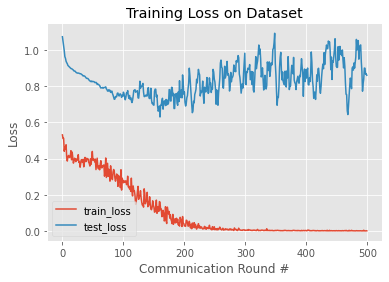

In [39]:
import matplotlib.pyplot as plt
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Communication Round #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH_LOSS)
# serialize the model to disk

**Accuracy**

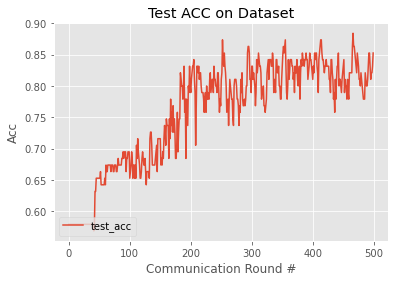

In [40]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["test_acc"], label="test_acc")
plt.title("Test ACC on Dataset")
plt.xlabel("Communication Round #")
plt.ylabel("Acc")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH_ACC)

**Save historical in a JSON file**

In [41]:
# load json module
import json



# create json object from dictionary
json = json.dumps(H)

# open file for writing, "w" 
f = open(PLOT_PATH_HIS,"w")

# write json object to file
f.write(json)

# close file
f.close()

### **Save Final Model**

In [42]:
if selected_method == "AVG":
  #Save general model
  H_avg=H
  torch.save(global_model, MODEL_PATH_glob)

if selected_method == "ENSEMBLE":
  H_ensemble=H
  #Save Ensemble Model Global
  torch.save(global_models_ensemble, MODEL_PATH_glob)
  #Save Model by Model
  model_number=0
  for model in global_models_ensemble:
    model_name="vgg16_"+str(model_number)+".pth"
    #print(model_name)
    MODEL_PATH_new = os.path.join(MODEL_PATH, model_name)
    torch.save(model, MODEL_PATH_new)
    model_number+=1

### **Save Global Parameters**

In [43]:
print("[INFO] saving Model Parameters...")
f = open(MODEL_PATH_param, "w")
f.write(str(Glob_Param))
f.close()

[INFO] saving Model Parameters...


### **Save Transformation**

In [44]:
print("[INFO] saving Model Transformation...")
f = open(MODEL_PATH_trans, "w")
f.write(str(train_transforms))
f.close()

[INFO] saving Model Transformation...


### **Save Best Model Round**

In [45]:
print("[INFO] saving Best Model Round...")
MODEL_PATH_best_round = os.path.join(MODEL_PATH, "best_model_round.txt")
f = open(MODEL_PATH_best_round, "w")
f.write(str(Best))
f.close()

[INFO] saving Best Model Round...


# 8. Predict Test Dataset to check Generalization Accuracy

### Load Model

In [46]:
loaded_model = torch.load(MODEL_PATH_glob, map_location=DEVICE)

### Functions to Predict

**Predict a Dataset**

In [47]:
def prediction_dataset(global_model, test_loader, method):
  if method == "ENSEMBLE":
    for model in global_model:
        model.eval()
  else:
    global_model.eval()

  pred_final=[]
  target_final=[]
  correct = 0
  confusion_matrix_torch = torch.zeros(num_classes, num_classes)
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                data = data.float()
                if method == "ENSEMBLE": 
                  global_output=[]
                  for model in global_model:
                    output_model = model(data)
                    global_output.append(output_model)
                  final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
                  pred = final_output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()
                if method == "AVG":
                  output = global_model(data)
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

                for t, p in zip(target.view(-1), pred.view(-1)):
                  confusion_matrix_torch[t.long(), p.long()] += 1
                pred_final.extend(pred.to('cpu').numpy().tolist())
                target_final.extend(target.to('cpu').numpy().tolist())

  acc = correct/len(test_loader.dataset)

  return target_final, pred_final, confusion_matrix_torch, acc

**Predict a simple Image**

In [48]:
def predict_image(global_model, image, method):
    if method == "ENSEMBLE":
      global_output=[]
      for model in global_model:
        model.eval()
        output_model = model(image)
        global_output.append(output_model)
      final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
      pred = final_output[0].argmax(dim=1, keepdim=True)
    
    if method == "AVG":
      global_model.eval()
      output_model = global_model(image)
      pred = output_model.argmax(dim=1, keepdim=True)
    
    return pred

### Precit Global Validation Dataset

In [49]:
target_final, pred_final, confusion_matrix_pred, acc = prediction_dataset(loaded_model, val_loader, selected_method)
print("Final Confusion Matrix: ")
print(confusion_matrix_pred)
print(acc)

Final Confusion Matrix: 
tensor([[53.,  1.,  2.],
        [10., 17.,  0.],
        [ 5.,  0.,  8.]])
0.8125


**Get different metrics**

In [50]:
confusion_matrix_skl=confusion_matrix(target_final, pred_final)
F1_skl=f1_score(target_final, pred_final, average='micro')
recall_skl=recall_score(target_final, pred_final, average='micro')
precision_skl=precision_score(target_final, pred_final, average='micro')
precision_recall_fscore_skl=precision_recall_fscore_support(target_final, pred_final, average='micro')
print(classification_report(target_final, pred_final, target_names=classes))

              precision    recall  f1-score   support

      benign       0.78      0.95      0.85        56
   malignant       0.94      0.63      0.76        27
      normal       0.80      0.62      0.70        13

    accuracy                           0.81        96
   macro avg       0.84      0.73      0.77        96
weighted avg       0.83      0.81      0.81        96



### Precit Each Client Validation Dataset

In [51]:
if len(clients_list)>1:
  i=0
  for client in clients_list:
    print("Validation Accuracy Client: ", client)
    target_final, pred_final, confusion_matrix_pred, acc = prediction_dataset(loaded_model, val_loader_client[i], selected_method)
    print(confusion_matrix_pred)
    if client=="B":
      print(classification_report(target_final, pred_final, target_names=classes))
    else:
      print(classification_report(target_final, pred_final, target_names=classes))
    i+=1

Validation Accuracy Client:  A
tensor([[42.,  0.,  2.],
        [ 7., 14.,  0.],
        [ 5.,  0.,  8.]])
              precision    recall  f1-score   support

      benign       0.78      0.95      0.86        44
   malignant       1.00      0.67      0.80        21
      normal       0.80      0.62      0.70        13

    accuracy                           0.82        78
   macro avg       0.86      0.75      0.78        78
weighted avg       0.84      0.82      0.81        78

Validation Accuracy Client:  B
tensor([[11.,  1.,  0.],
        [ 3.,  3.,  0.],
        [ 0.,  0.,  0.]])


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

# 9. Plot Some Prediction Example

In [ ]:
def prepare_plot(origImage, real_label, pred_label):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    # plot the original image, its mask, and the predicted mask
    ax.imshow(origImage, cmap="gray")
    # set the titles of the subplots
    ax.set_title("Image Label: %s; Predicated Label: %s" % (real_label,pred_label))
    
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [ ]:
def make_predictions(model, imagePath, method):
    # set model to evaluation mode
    #model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (image_size, image_size))
        
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        real_name = filename.split(".")[0]
        type_file = filename.split(".")[1]
        #real_label = filename.split(" ")[0]
        real_label = (imagePath.split('/')[-2]) 
    

        ###########################################################
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        #image = np.transpose(image, (2, 1))
        
        image = np.expand_dims(image, 0)
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        
        pred_label = predict_image(model, image, method)

        pred_label=idx_to_class[pred_label.to('cpu').tolist()[0][0]]
        #print(orig.shape)
        #print(gtMask.shape)
        #print(predMask.shape)
        # prepare a plot for visualization
        prepare_plot(orig, real_label, pred_label)

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
print(imagePaths)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(loaded_model, path, method=selected_method)

In [ ]:
torch.cuda.empty_cache()